In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, make_scorer, recall_score
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('future.no_silent_downcasting', True)

## EDA

### Functions

In [5]:
def histogram(df, column, bins, title, x_label, y_label, color_by=None,kde=False):
    plt.figure(figsize=(10, 6))
    
    sns.histplot(data=df, x=column, bins=bins, kde=kde, hue=color_by, multiple='stack')
    
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.tight_layout()
    plt.show()

In [6]:
def stacked_bar(df, column_x, column_y, title, x_label, y_label, colormap='tab20', rotation=45, legend='', agg_method='count',value=''):
    if pd.api.types.is_datetime64_any_dtype(df[column_x]):
        df[column_x] = pd.to_datetime(df[column_x]).dt.date
    else:
        df[column_x] = df[column_x].astype(str)
    
    if agg_method == 'count':
        grouped = df.groupby([column_x, column_y]).size().reset_index(name='value')
    elif agg_method == 'sum':
        grouped = df.groupby([column_x, column_y])[value].sum().reset_index()
        grouped = grouped.rename(columns={value: 'value'})

    elif agg_method == 'nunique':
        grouped = df.groupby([column_x, column_y]).nunique().reset_index()
    else:
        raise ValueError("aggegation method must be 'count', 'sum', or 'nunique'")
    
    grouped_pivot = grouped.pivot(index=column_x, columns=column_y, values='value').fillna(0)

    grouped_pivot.plot(kind='bar', stacked=True, figsize=(14, 6), colormap=colormap)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.xticks(rotation=rotation)
    plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

In [7]:
def stacked_bar_percent(df, column_x, column_y, title, x_label, y_label, colormap='tab20', rotation=45, legend='', agg_method='count',value=''):
    if pd.api.types.is_datetime64_any_dtype(df[column_x]):
        df[column_x] = pd.to_datetime(df[column_x]).dt.date
    else:
        df[column_x] = df[column_x].astype(str)
    
    if agg_method == 'count':
        grouped = df.groupby([column_x, column_y]).size().reset_index(name='value')
    elif agg_method == 'sum':
        grouped = df.groupby([column_x, column_y])[value].sum().reset_index()
        grouped = grouped.rename(columns={value: 'value'})
    elif agg_method == 'nunique':
        grouped = df.groupby([column_x, column_y]).nunique().reset_index()
    else:
        raise ValueError("Aggregation method must be 'count', 'sum', or 'nunique'")
    
    grouped_pivot = grouped.pivot(index=column_x, columns=column_y, values='value').fillna(0)

    grouped_pivot_percent = grouped_pivot.div(grouped_pivot.sum(axis=1), axis=0) * 100

    grouped_pivot_percent.plot(kind='bar', stacked=True, figsize=(14, 6), colormap=colormap)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label + " (%)")
    plt.xticks(rotation=rotation)
    plt.legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


### Data Loading

**_Historical customer data_**: Customer data such as usage, sign up date, forecasted usage, etc.

In [8]:
client_df = pd.read_csv("Data/client_data.csv")
client_df.shape

(14606, 26)

In [9]:
client_df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0


**_Historical pricing data_**: variable and fixed pricing data, etc.

In [10]:
price_df = pd.read_csv("Data/price_data.csv")
price_df.shape

(193002, 8)

In [11]:
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


### Descriptive Statistics

#### Historical Customer Data

In [12]:
client_df['date_activ']=pd.to_datetime(client_df['date_activ'])
client_df['date_end']=pd.to_datetime(client_df['date_end'])
client_df['date_modif_prod']=pd.to_datetime(client_df['date_modif_prod'])
client_df['date_renewal']=pd.to_datetime(client_df['date_renewal'])

In [13]:
client_df['has_gas'] = client_df['has_gas'].replace({'t': True, 'f': False})

In [14]:
client_df[['cons_12m','cons_gas_12m']] = client_df[['cons_12m','cons_gas_12m']].astype(int)
client_df[['cons_12m','cons_gas_12m']] = client_df[['cons_12m','cons_gas_12m']].replace(0, np.nan)

In [15]:
#Service Type
conditions = [
    client_df['cons_12m'].notna() & client_df['cons_gas_12m'].notna(),
    client_df['cons_12m'].notna() & client_df['cons_gas_12m'].isna(),
    client_df['cons_12m'].isna() & client_df['cons_gas_12m'].notna(),
    client_df['cons_12m'].isna() & client_df['cons_gas_12m'].isna()
]

choices = ['Electrical & Gas', 'Electrical', 'Gas', 'Missing']

client_df['service_type'] = np.select(conditions, choices, default='Missing')
client_df['service_type'].value_counts()

service_type
Electrical          11892
Electrical & Gas     2597
Missing               102
Gas                    15
Name: count, dtype: int64

In [16]:
condition = (client_df['service_type'].isin(['Gas', 'Missing'])) & (client_df['cons_last_month'] == 0)

client_df.loc[condition, 'cons_last_month'] = np.nan

In [17]:
client_df['churn'] = client_df['churn'].replace(0, "Retention")
client_df['churn'] = client_df['churn'].replace(1, "Churn")

In [18]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14489 non-null  float64       
 3   cons_gas_12m                    2612 non-null   float64       
 4   cons_last_month                 14489 non-null  float64       
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [19]:
print(client_df.isnull().sum().to_dict())

{'id': 0, 'channel_sales': 0, 'cons_12m': 117, 'cons_gas_12m': 11994, 'cons_last_month': 117, 'date_activ': 0, 'date_end': 0, 'date_modif_prod': 0, 'date_renewal': 0, 'forecast_cons_12m': 0, 'forecast_cons_year': 0, 'forecast_discount_energy': 0, 'forecast_meter_rent_12m': 0, 'forecast_price_energy_off_peak': 0, 'forecast_price_energy_peak': 0, 'forecast_price_pow_off_peak': 0, 'has_gas': 0, 'imp_cons': 0, 'margin_gross_pow_ele': 0, 'margin_net_pow_ele': 0, 'nb_prod_act': 0, 'net_margin': 0, 'num_years_antig': 0, 'origin_up': 0, 'pow_max': 0, 'churn': 0, 'service_type': 0}


In [20]:
print(client_df.nunique().to_dict())

{'id': 14606, 'channel_sales': 8, 'cons_12m': 11064, 'cons_gas_12m': 2111, 'cons_last_month': 4751, 'date_activ': 1796, 'date_end': 368, 'date_modif_prod': 2129, 'date_renewal': 386, 'forecast_cons_12m': 13993, 'forecast_cons_year': 4218, 'forecast_discount_energy': 12, 'forecast_meter_rent_12m': 3528, 'forecast_price_energy_off_peak': 516, 'forecast_price_energy_peak': 329, 'forecast_price_pow_off_peak': 41, 'has_gas': 2, 'imp_cons': 7752, 'margin_gross_pow_ele': 2391, 'margin_net_pow_ele': 2391, 'nb_prod_act': 10, 'net_margin': 11965, 'num_years_antig': 13, 'origin_up': 6, 'pow_max': 698, 'churn': 2, 'service_type': 4}


In [21]:
client_df.describe()

,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,pow_max
count,1.448900e+04,2.612000e+03,14489.000000,14606,14606,14606,14606,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000,14606.000000
mean,1.605060e+05,1.570893e+05,16220.200152,2011-01-28 07:54:18.879912448,2016-07-27 20:48:26.422018560,2013-01-02 12:29:10.951663872,2015-07-21 06:59:00.353279488,1868.614880,1399.762906,0.966726,63.086871,0.137283,0.050491,43.130056,152.786896,24.565121,24.562517,1.292346,189.264522,4.997809,18.135136
min,1.000000e+00,1.100000e+01,0.000000,2003-05-09 00:00:00,2016-01-28 00:00:00,2003-05-09 00:00:00,2013-06-26 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,3.300000
25%,5.802000e+03,6.098500e+03,0.000000,2010-01-15 00:00:00,2016-04-27 06:00:00,2010-08-12 00:00:00,2015-04-17 00:00:00,494.995000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701,0.000000,14.280000,14.280000,1.000000,50.712500,4.000000,12.500000
50%,1.428700e+04,1.984850e+04,811.000000,2011-03-04 00:00:00,2016-08-01 00:00:00,2013-06-19 00:00:00,2015-07-27 00:00:00,1112.875000,314.000000,0.000000,18.795000,0.143166,0.084138,44.311378,37.395000,21.640000,21.640000,1.000000,112.530000,5.000000,13.856000
75%,4.116100e+04,9.768025e+04,3427.000000,2012-04-19 00:00:00,2016-10-31 00:00:00,2015-06-16 00:00:00,2015-10-29 00:00:00,2401.790000,1745.750000,0.000000,131.030000,0.146348,0.098837,44.311378,193.980000,29.880000,29.880000,1.000000,243.097500,6.000000,19.172500
max,6.207104e+06,4.154590e+06,771203.000000,2014-09-01 00:00:00,2017-06-13 00:00:00,2016-01-29 00:00:00,2016-01-28 00:00:00,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378,15042.790000,374.640000,374.640000,32.000000,24570.650000,13.000000,320.000000
std,5.755969e+05,3.581851e+05,64607.256023,NaN,NaN,NaN,NaN,2387.571531,3247.786255,5.108289,66.165783,0.024623,0.049037,4.485988,341.369366,20.231172,20.230280,0.709774,311.798130,1.611749,13.534743


#### Historical Pricing Data

In [22]:
#data formatting
price_df['price_date']=pd.to_datetime(price_df['price_date'])
price_df['date_str'] = pd.to_datetime(price_df['price_date']).dt.strftime('%Y%m%d')
price_df['Primary_key']=price_df['id']+'-'+price_df['date_str']
price_df.drop(columns=['date_str'],inplace=True)

In [23]:
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
 8   Primary_key         193002 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(2)
memory usage: 13.3+ MB


**_Observation_**: de-duplication is already done for price_df -> so, no need to do it again

In [24]:
print(price_df.isnull().sum().to_dict())

{'id': 0, 'price_date': 0, 'price_off_peak_var': 0, 'price_peak_var': 0, 'price_mid_peak_var': 0, 'price_off_peak_fix': 0, 'price_peak_fix': 0, 'price_mid_peak_fix': 0, 'Primary_key': 0}


In [25]:
print(price_df.nunique().to_dict())

{'id': 16096, 'price_date': 12, 'price_off_peak_var': 1853, 'price_peak_var': 1189, 'price_mid_peak_var': 711, 'price_off_peak_fix': 66, 'price_peak_fix': 31, 'price_mid_peak_fix': 28, 'Primary_key': 193002}


In [26]:
price_df.describe()

,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,193002,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000,193002.000000
mean,2015-06-16 12:50:49.933161216,0.141027,0.054630,0.030496,43.334477,10.622875,6.409984
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-04-01 00:00:00,0.125976,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-07-01 00:00:00,0.146033,0.085483,0.000000,44.266930,0.000000,0.000000
75%,2015-10-01 00:00:00,0.151635,0.101673,0.072558,44.444710,24.339581,16.226389
max,2015-12-01 00:00:00,0.280700,0.229788,0.114102,59.444710,36.490692,17.458221
std,NaN,0.025032,0.049924,0.036298,5.410297,12.841895,7.773592


In [27]:
price_df['price_date'].value_counts()

price_date
2015-08-01    16094
2015-12-01    16094
2015-07-01    16090
2015-11-01    16087
2015-06-01    16085
2015-10-01    16085
2015-02-01    16082
2015-09-01    16082
2015-05-01    16080
2015-04-01    16079
2015-03-01    16074
2015-01-01    16070
Name: count, dtype: int64

#### Pricing & Customer Data -> Data Linking

In [28]:
price_dec_2015 = price_df[price_df['price_date']=='2015-12-01']
price_dec_2015.shape

(16094, 9)

In [29]:
price_dec_2015.describe()

,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
count,16094,16094.000000,16094.000000,16094.000000,16094.000000,16094.000000,16094.000000
mean,2015-12-01 00:00:00,0.138011,0.053957,0.030732,43.504177,10.644109,6.427104
min,2015-12-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015-12-01 00:00:00,0.118238,0.000000,0.000000,40.728885,0.000000,0.000000
50%,2015-12-01 00:00:00,0.144524,0.086054,0.000000,44.444710,0.000000,0.000000
75%,2015-12-01 00:00:00,0.147983,0.100491,0.073625,44.444710,24.437330,16.291555
max,2015-12-01 00:00:00,0.276238,0.196029,0.103502,59.444710,36.490689,17.458221
std,NaN,0.026221,0.049190,0.036617,5.464370,12.872326,7.799503


In [30]:
client_df= pd.merge(client_df,price_dec_2015,on='id',how='left')
client_df.shape

(14606, 35)

In [31]:
missing_ids = price_dec_2015['id'].nunique()-client_df['id'].nunique()
missing_ids

1488

**_Observation_**: 1490 client company identifiers are available in Price data (dec 2015 but not in Customer data.

#### Total cost spent on Dec 2015 by each client Company

**_Assumption_**: cons_last_month is split equally across 3 periods.
- 1/3rd of cons_last_month → Off-Peak usage
- 1/3rd of cons_last_month → Mid-Peak usage
- 1/3rd of cons_last_month → Peak usage

In [32]:
client_df['consumption_off_peak_dec_2015'] = client_df['cons_last_month'] / 3
client_df['consumption_mid_peak_dec_2015'] = client_df['cons_last_month'] / 3
client_df['consumption_peak_dec_2015'] = client_df['cons_last_month'] / 3

client_df['cost_off_peak_dec_2015'] = (client_df['consumption_off_peak_dec_2015'] * client_df['price_off_peak_var']) + client_df['price_off_peak_fix']
client_df['cost_mid_peak_dec_2015'] = (client_df['consumption_mid_peak_dec_2015'] * client_df['price_mid_peak_var']) + client_df['price_mid_peak_fix']
client_df['cost_peak_dec_2015'] = (client_df['consumption_peak_dec_2015'] * client_df['price_peak_var']) + client_df['price_peak_fix']

client_df['estimated_total_cost_dec_2015'] = client_df['cost_off_peak_dec_2015'] + client_df['cost_mid_peak_dec_2015'] + client_df['cost_peak_dec_2015']

client_df.groupby('churn')[['cons_last_month','estimated_total_cost_dec_2015']].sum()


,cons_last_month,estimated_total_cost_dec_2015
churn,,
Churn,10224235.0,9.386572e+05
Retention,224790245.0,1.978363e+07


#### Total cost spent on last 12 months by each client Company

**_Assumption_**: cons_12m is equally split across months and across time periods (off/mid/peak)

In [33]:
client_df['consumption_per_month'] = client_df['cons_12m'] / 12

client_df['consumption_off_peak_month'] = client_df['consumption_per_month'] / 3
client_df['consumption_mid_peak_month'] = client_df['consumption_per_month'] / 3
client_df['consumption_peak_month'] = client_df['consumption_per_month'] / 3

price_expanded_df = price_df.merge(client_df[['id', 'consumption_off_peak_month', 'consumption_mid_peak_month', 'consumption_peak_month']], on='id', how='left')

price_expanded_df['monthly_cost_off_peak'] = (price_expanded_df['consumption_off_peak_month'] * price_expanded_df['price_off_peak_var']) + price_expanded_df['price_off_peak_fix']
price_expanded_df['monthly_cost_mid_peak'] = (price_expanded_df['consumption_mid_peak_month'] * price_expanded_df['price_mid_peak_var']) + price_expanded_df['price_mid_peak_fix']
price_expanded_df['monthly_cost_peak'] = (price_expanded_df['consumption_peak_month'] * price_expanded_df['price_peak_var']) + price_expanded_df['price_peak_fix']

price_expanded_df['total_monthly_cost'] = price_expanded_df['monthly_cost_off_peak'] + price_expanded_df['monthly_cost_mid_peak'] + price_expanded_df['monthly_cost_peak']

In [34]:
total_12m_cost = price_expanded_df.groupby('id')['total_monthly_cost'].sum().reset_index()
total_12m_cost = total_12m_cost.rename(columns={'total_monthly_cost': 'estimated_total_cost_last_12m'})

client_df = client_df.merge(total_12m_cost, on='id', how='left')
client_df.groupby('churn')[['cons_12m','estimated_total_cost_last_12m']].sum()

,cons_12m,estimated_total_cost_last_12m
churn,,
Churn,1.119059e+08,1.044849e+07
Retention,2.213666e+09,1.972122e+08


In [35]:
cost_threshold = client_df['estimated_total_cost_last_12m'].quantile(0.75)

client_df['high_cost_flag'] = np.where(client_df['estimated_total_cost_last_12m'] >= cost_threshold, 1, 0)

pd.crosstab(client_df['high_cost_flag'], client_df['churn'], normalize='index') * 100

churn,Churn,Retention
high_cost_flag,,
0,9.850283,90.149717
1,9.309967,90.690033


### Data Visualization

In [36]:
print(client_df['service_type'].value_counts().to_dict())

{'Electrical': 11892, 'Electrical & Gas': 2597, 'Missing': 102, 'Gas': 15}


In [37]:
print(client_df['channel_sales'].value_counts().to_dict())

{'foosdfpfkusacimwkcsosbicdxkicaua': 6754, 'MISSING': 3725, 'lmkebamcaaclubfxadlmueccxoimlema': 1843, 'usilxuppasemubllopkaafesmlibmsdf': 1375, 'ewpakwlliwisiwduibdlfmalxowmwpci': 893, 'sddiedcslfslkckwlfkdpoeeailfpeds': 11, 'epumfxlbckeskwekxbiuasklxalciiuu': 3, 'fixdbufsefwooaasfcxdxadsiekoceaa': 2}


In [38]:
print(client_df['origin_up'].value_counts().to_dict())

{'lxidpiddsbxsbosboudacockeimpuepw': 7097, 'kamkkxfxxuwbdslkwifmmcsiusiuosws': 4294, 'ldkssxwpmemidmecebumciepifcamkci': 3148, 'MISSING': 64, 'usapbepcfoloekilkwsdiboslwaxobdp': 2, 'ewxeelcelemmiwuafmddpobolfuxioce': 1}


##### By Channel Sales

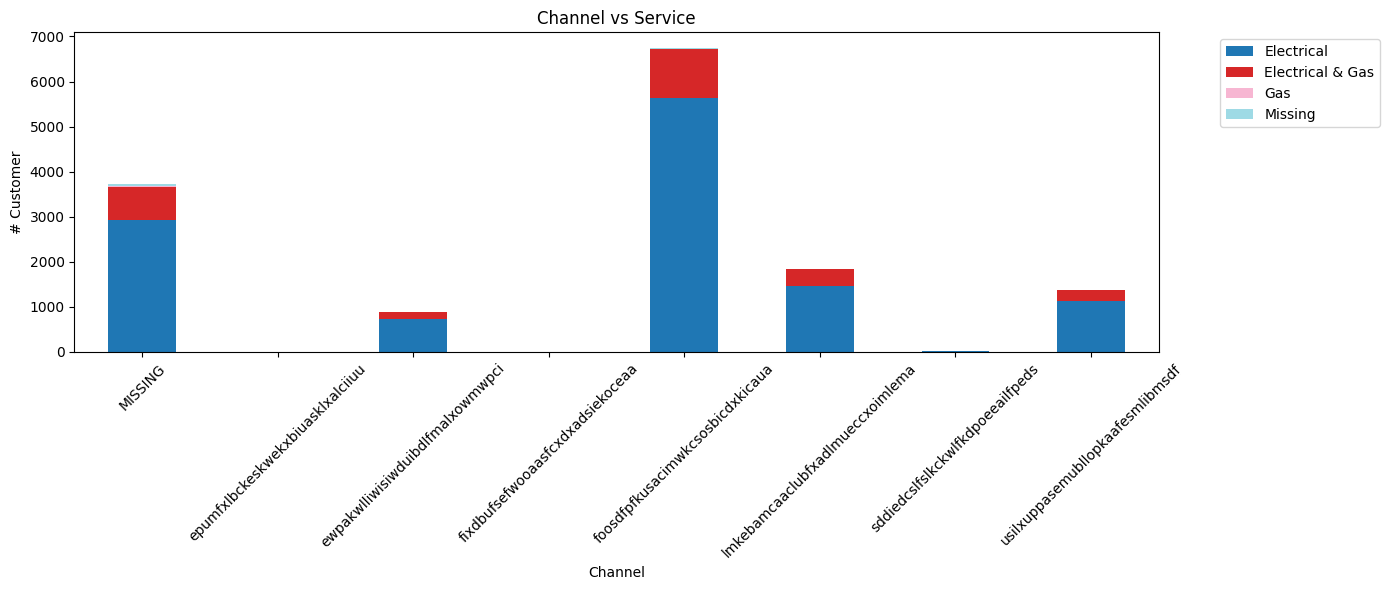

In [39]:
stacked_bar(client_df, 'channel_sales', 'service_type', 'Channel vs Service', 'Channel', '# Customer', agg_method='count')


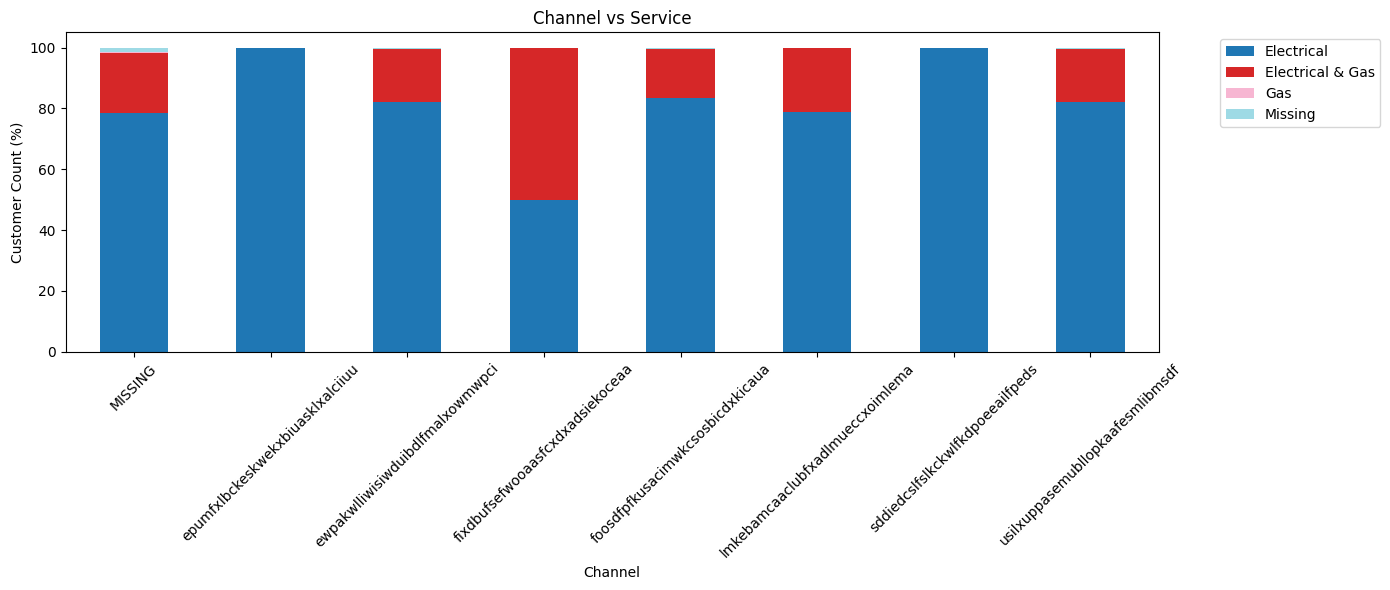

In [40]:
stacked_bar_percent(client_df, 'channel_sales', 'service_type', 'Channel vs Service', 'Channel', 'Customer Count', agg_method='count')

##### By Origin Up

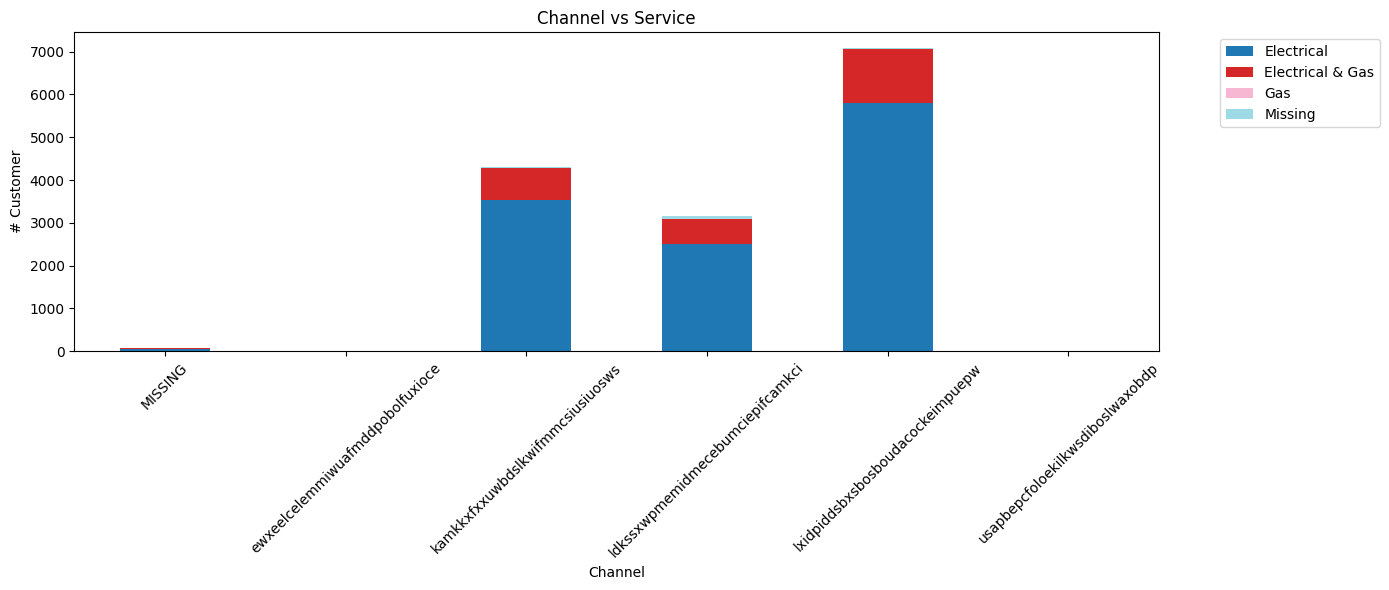

In [41]:
stacked_bar(client_df, 'origin_up', 'service_type', 'Channel vs Service', 'Channel', '# Customer', agg_method='count')


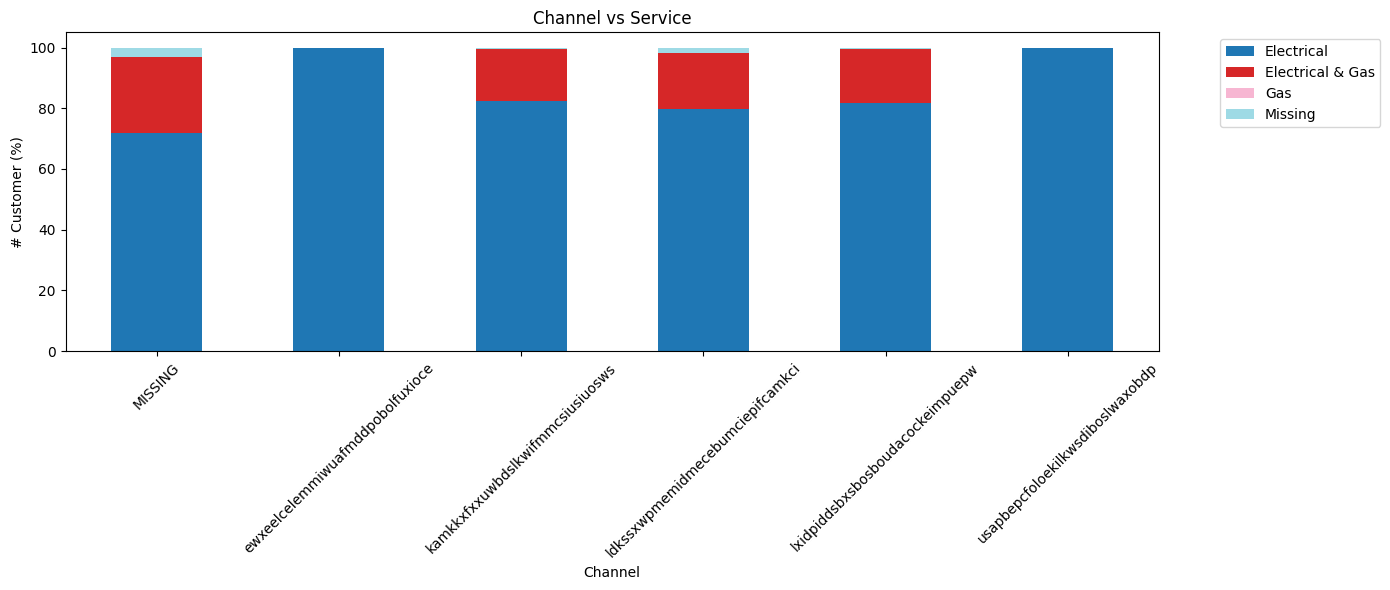

In [42]:
stacked_bar_percent(client_df, 'origin_up', 'service_type', 'Channel vs Service', 'Channel', '# Customer', agg_method='count')


#### Churn & Retention - Histogram

##### Electrical

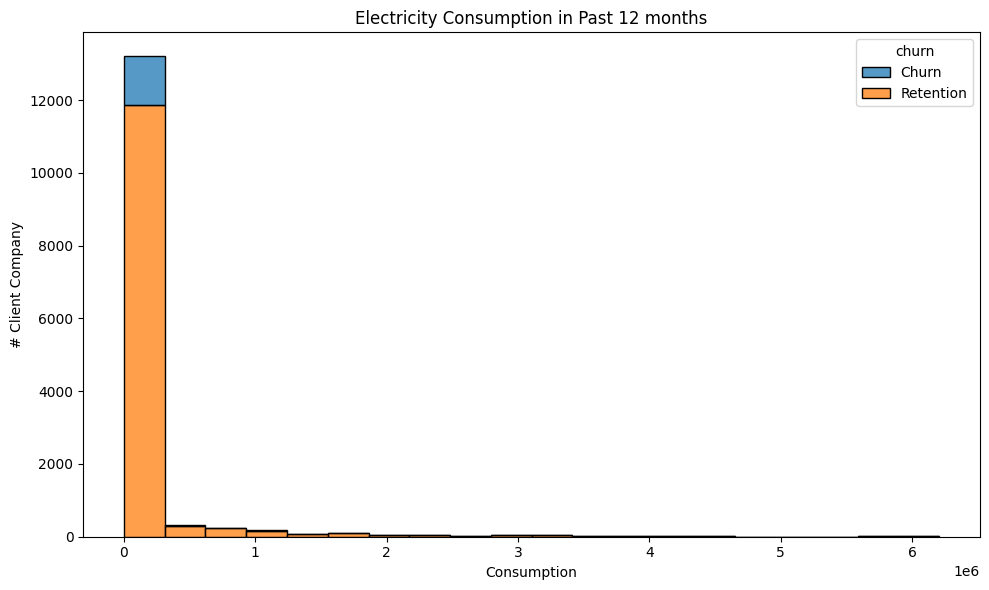

In [43]:
histogram(client_df, "cons_12m", 20, "Electricity Consumption in Past 12 months", "Consumption", "# Client Company", "churn" )

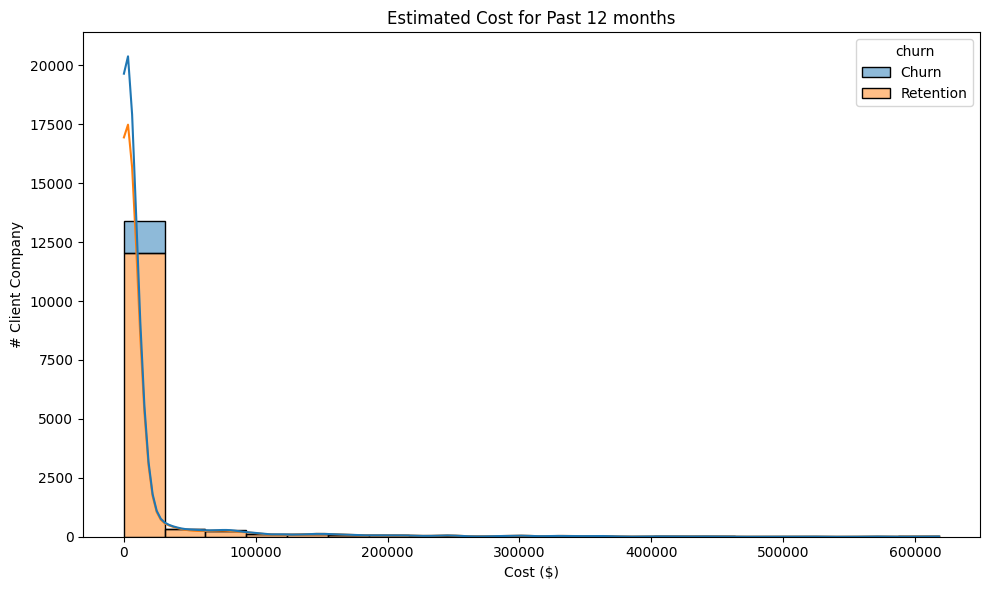

In [44]:
histogram(client_df, "estimated_total_cost_last_12m", 20, "Estimated Cost for Past 12 months", "Cost ($)", "# Client Company", "churn" ,kde=True)

**_Observation_**:
The majority of the customers are concentrated at low annual electricity costs (<$25,000).
However, churned customers are slightly skewed toward higher cost ranges compared to retained customers, confirming that cost sensitivity is a major churn driver.

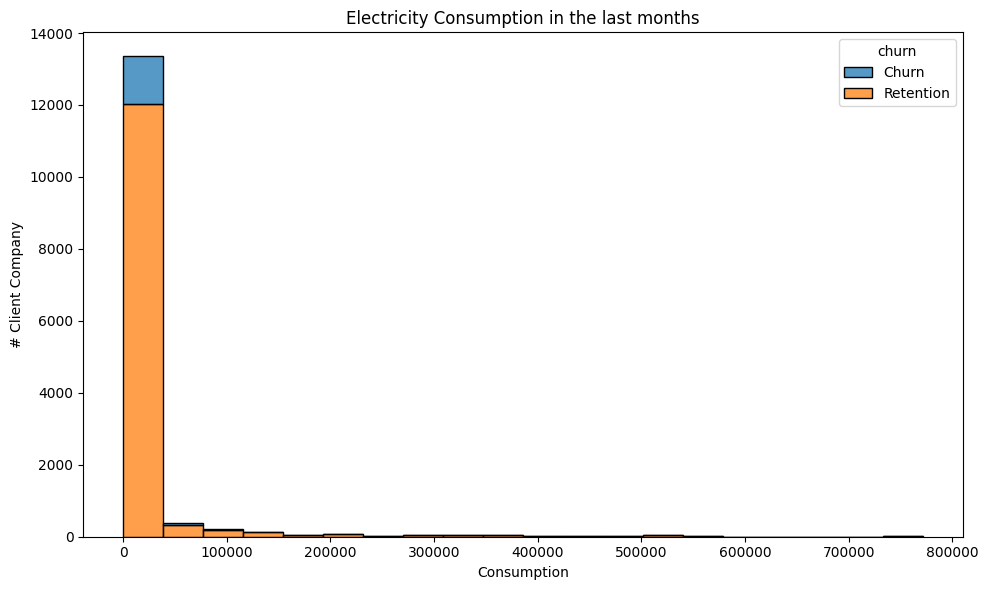

In [45]:
histogram(client_df, "cons_last_month", 20, "Electricity Consumption in the last months", "Consumption", "# Client Company", "churn" )

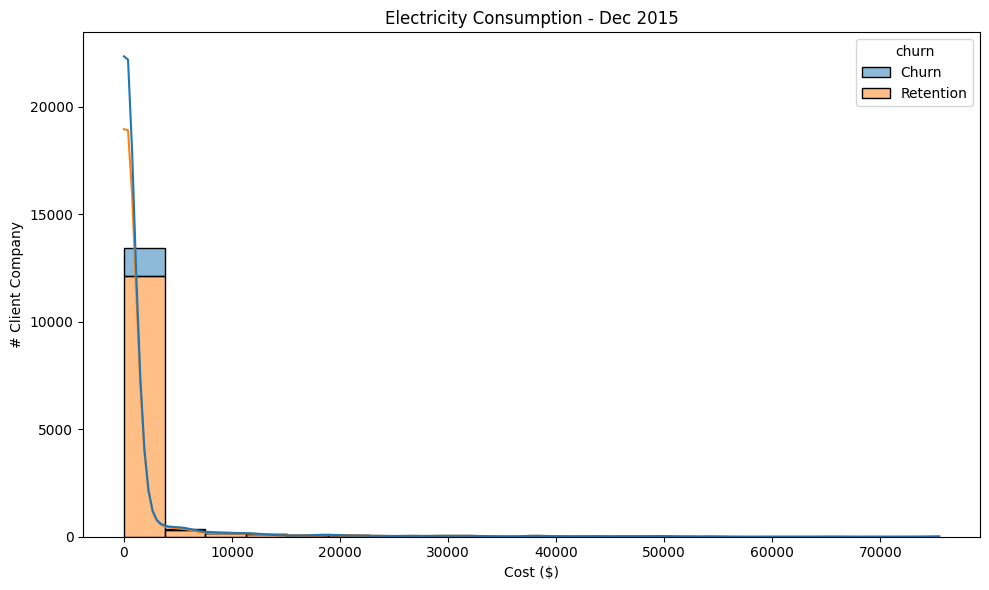

In [46]:
histogram(client_df, "estimated_total_cost_dec_2015", 20, "Electricity Consumption - Dec 2015", "Cost ($)", "# Client Company", "churn" ,kde=True)

##### Gas

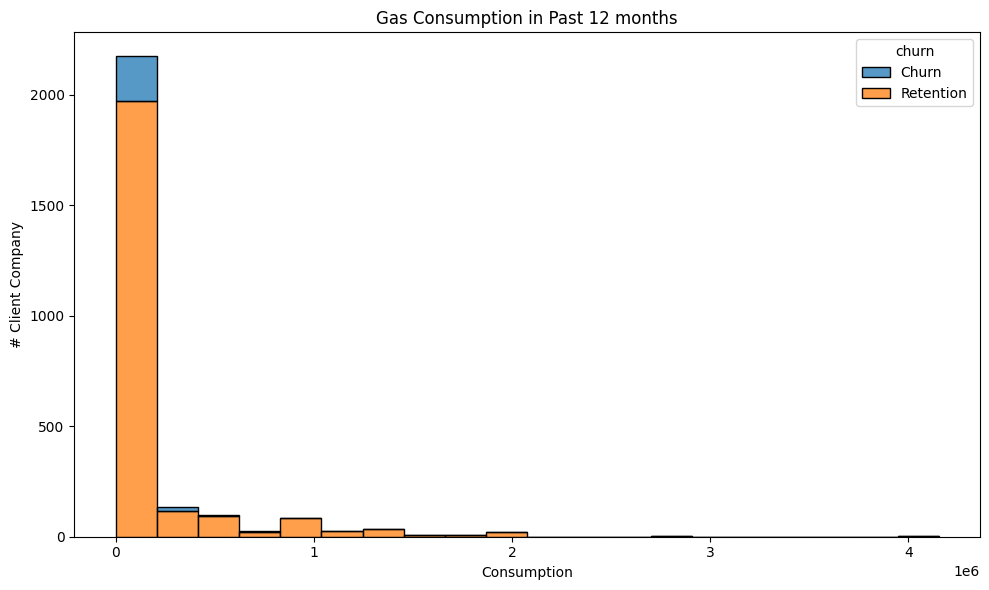

In [47]:
histogram(client_df, "cons_gas_12m", 20, "Gas Consumption in Past 12 months", "Consumption", "# Client Company", "churn" )

#### Churn & Retention - Categorical Fields

In [48]:
print(client_df['num_years_antig'].value_counts().to_dict())

{6: 4769, 4: 3982, 3: 2433, 5: 2317, 7: 509, 11: 185, 12: 110, 8: 103, 9: 92, 10: 81, 13: 13, 2: 11, 1: 1}


In [49]:
print(client_df['churn'].value_counts().to_dict())

{'Retention': 13187, 'Churn': 1419}


##### By Customer Sales

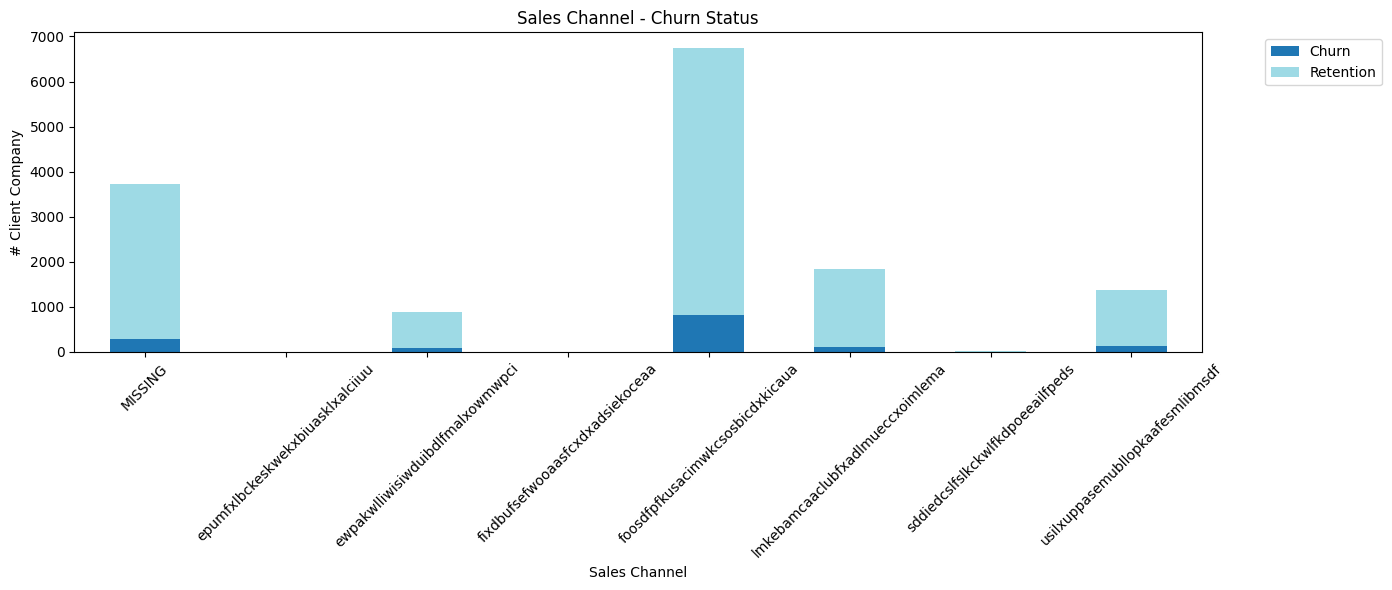

In [50]:
stacked_bar(client_df, 'channel_sales', 'churn', 'Sales Channel - Churn Status', 'Sales Channel', '# Client Company', agg_method='count')


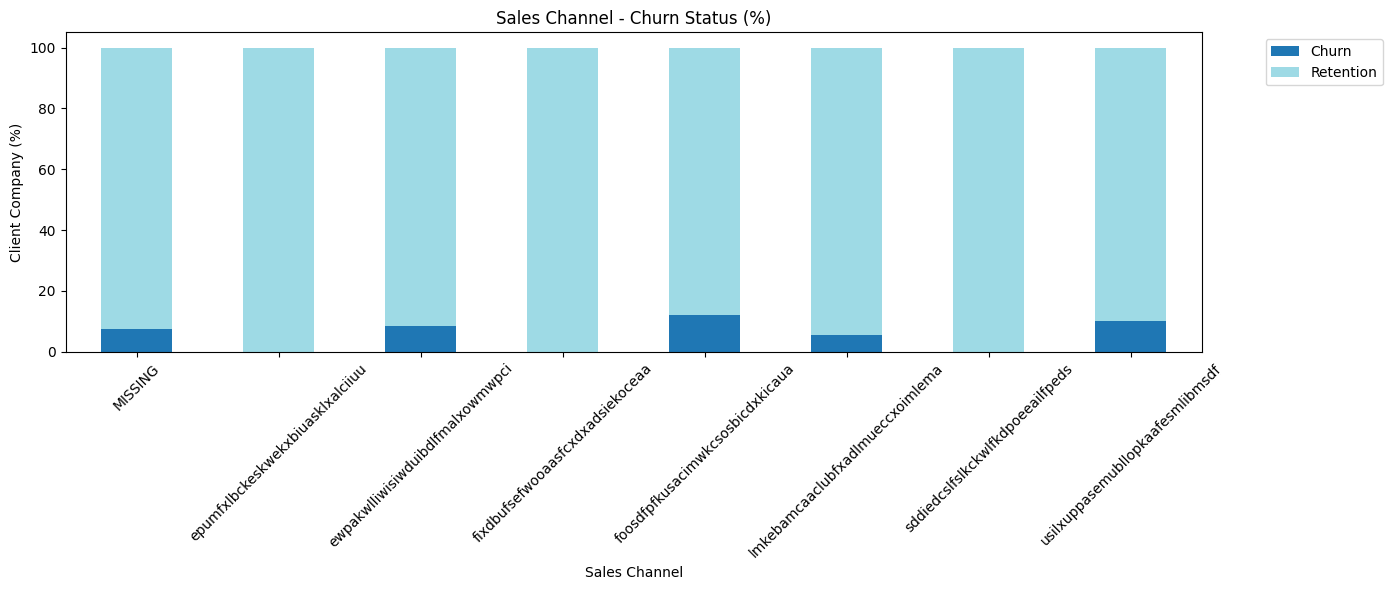

In [51]:
stacked_bar_percent(client_df, 'channel_sales', 'churn', 'Sales Channel - Churn Status (%)', 'Sales Channel', 'Client Company', agg_method='count')


##### By Service Type

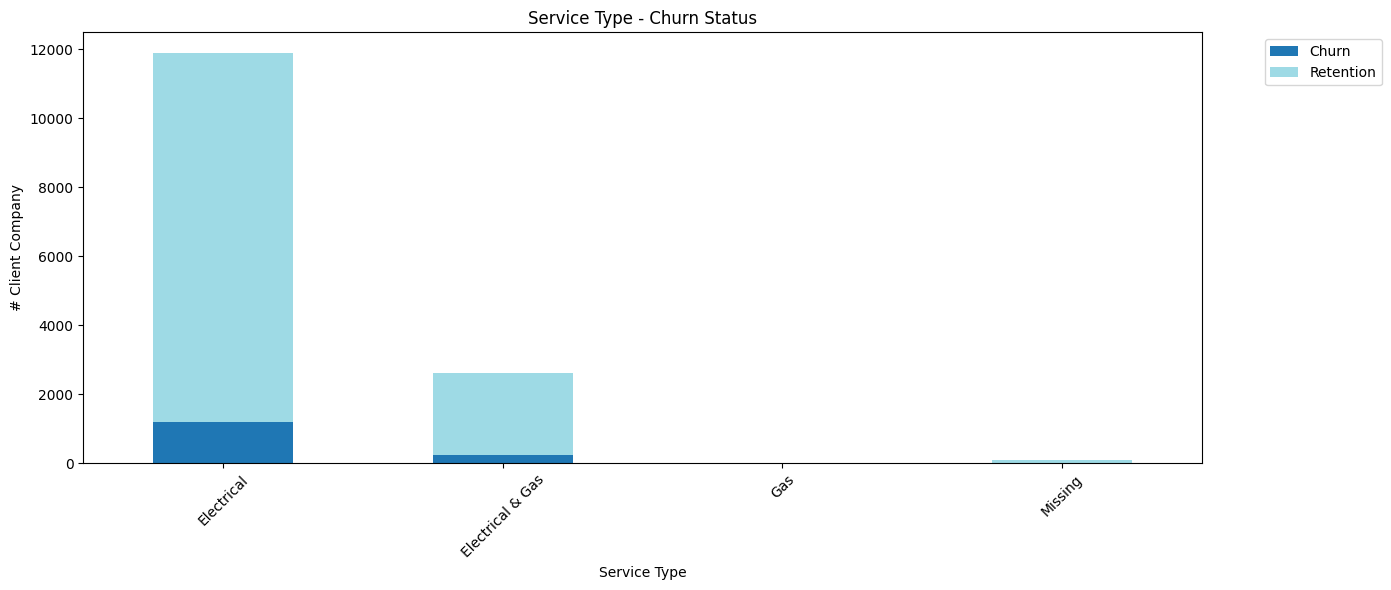

In [52]:
stacked_bar(client_df, 'service_type', 'churn', 'Service Type - Churn Status', 'Service Type', '# Client Company', agg_method='count')


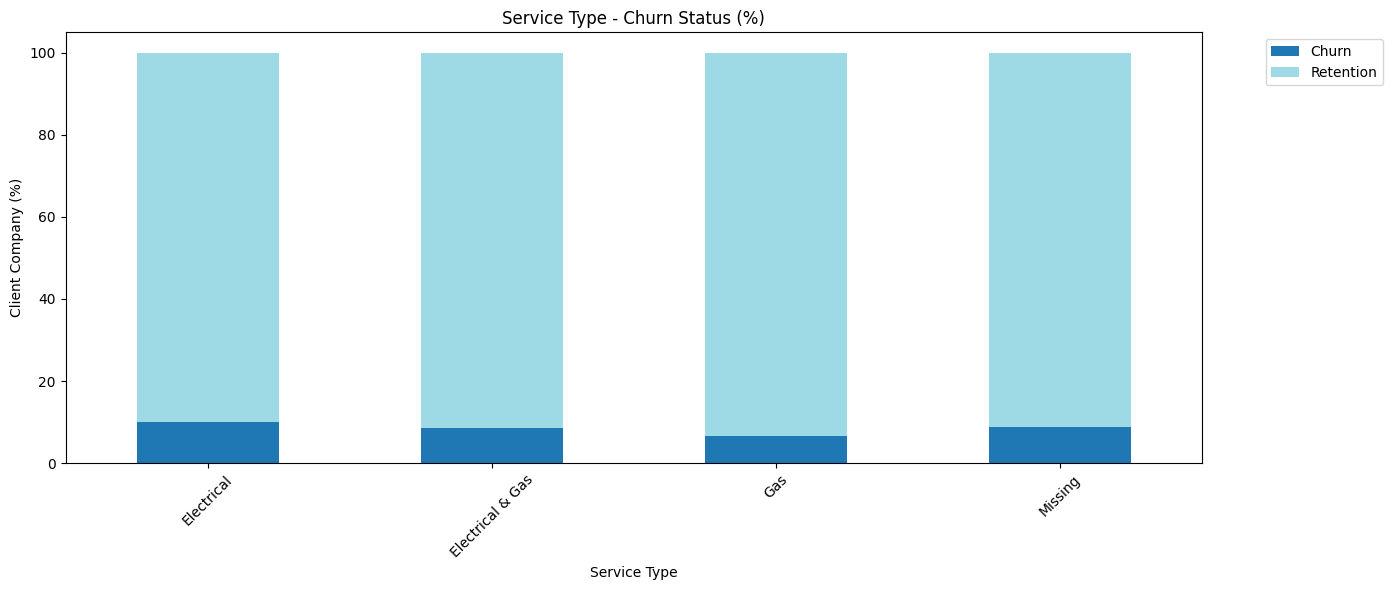

In [53]:
stacked_bar_percent(client_df, 'service_type', 'churn', 'Service Type - Churn Status (%)', 'Service Type', 'Client Company', agg_method='count')


##### By Origin Up

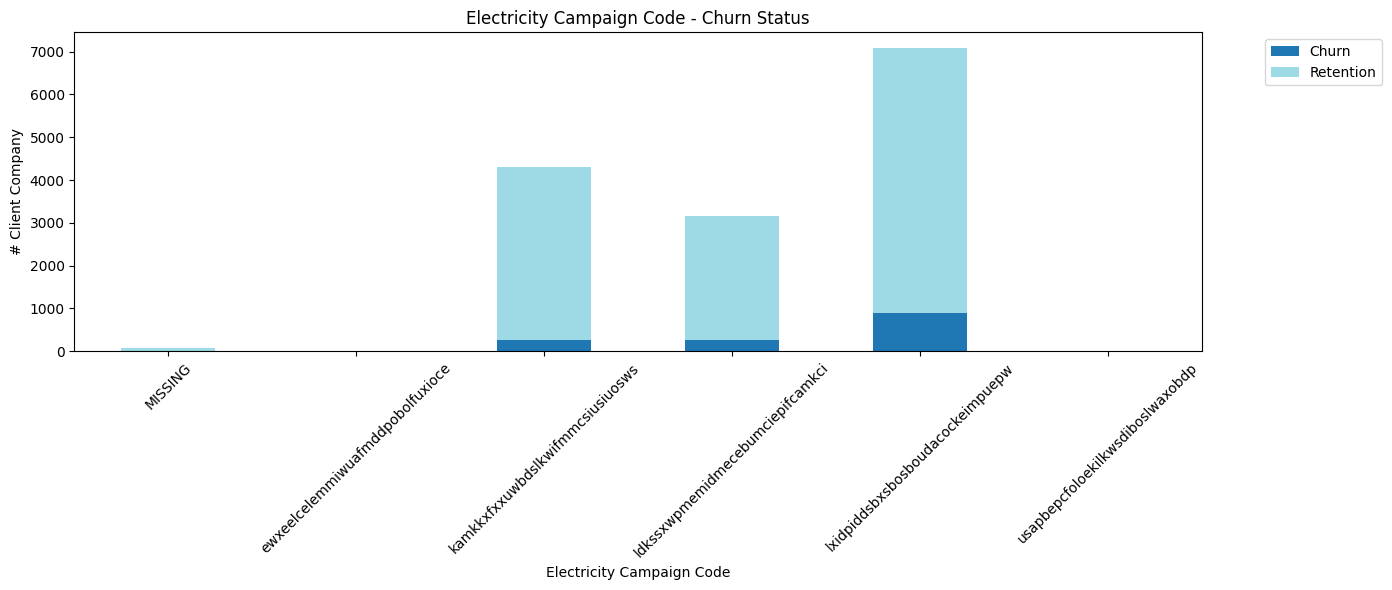

In [54]:
stacked_bar(client_df, 'origin_up', 'churn', 'Electricity Campaign Code - Churn Status', 'Electricity Campaign Code', '# Client Company', agg_method='count')


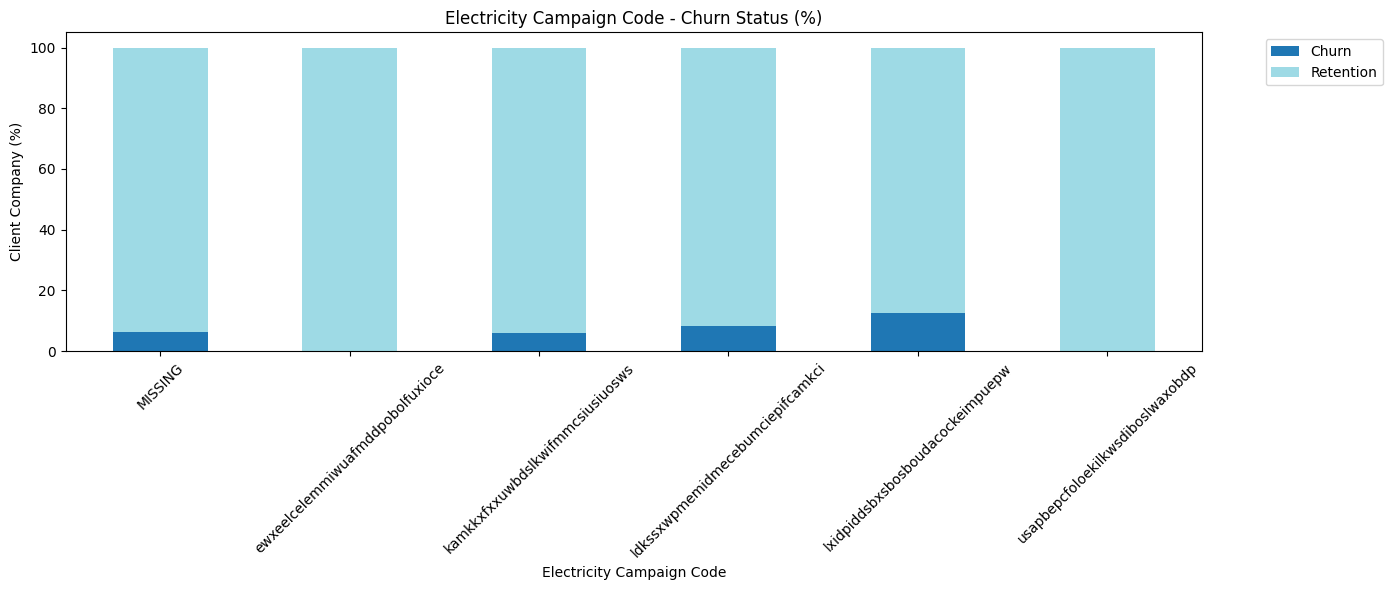

In [55]:
stacked_bar_percent(client_df, 'origin_up', 'churn', 'Electricity Campaign Code - Churn Status (%)', 'Electricity Campaign Code', 'Client Company', agg_method='count')


##### By Tenure

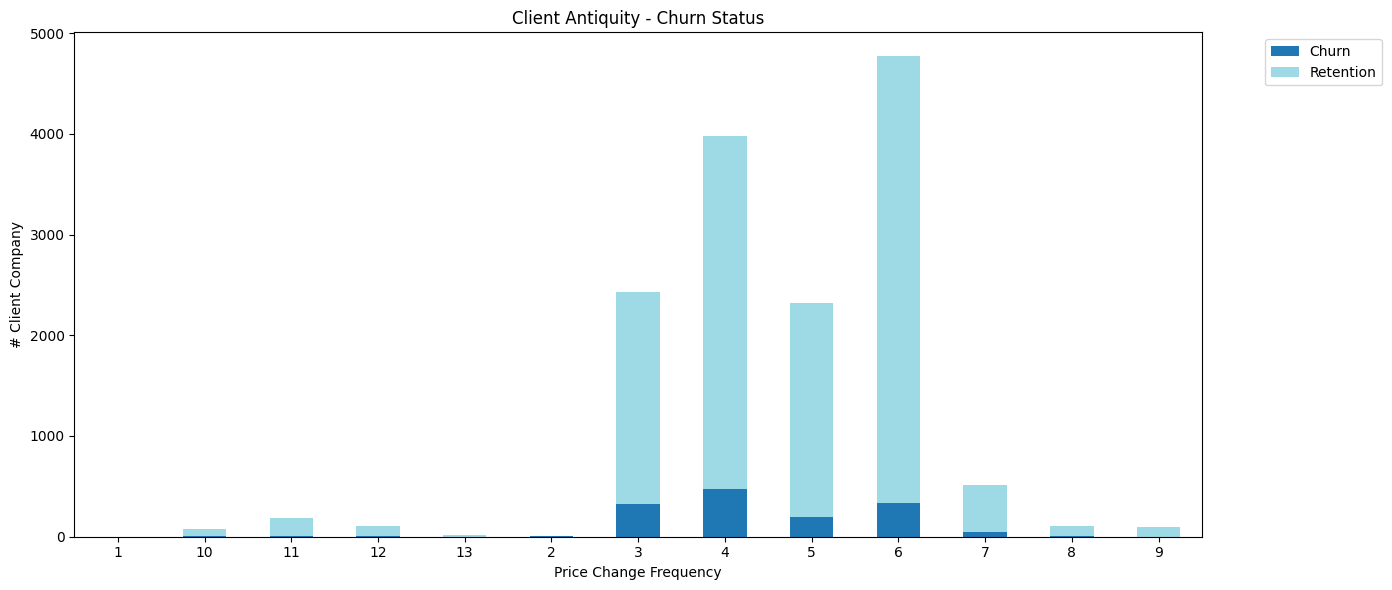

In [56]:
stacked_bar(client_df, 'num_years_antig', 'churn', 'Client Antiquity - Churn Status', 'Price Change Frequency', '# Client Company', agg_method='count',rotation=0)


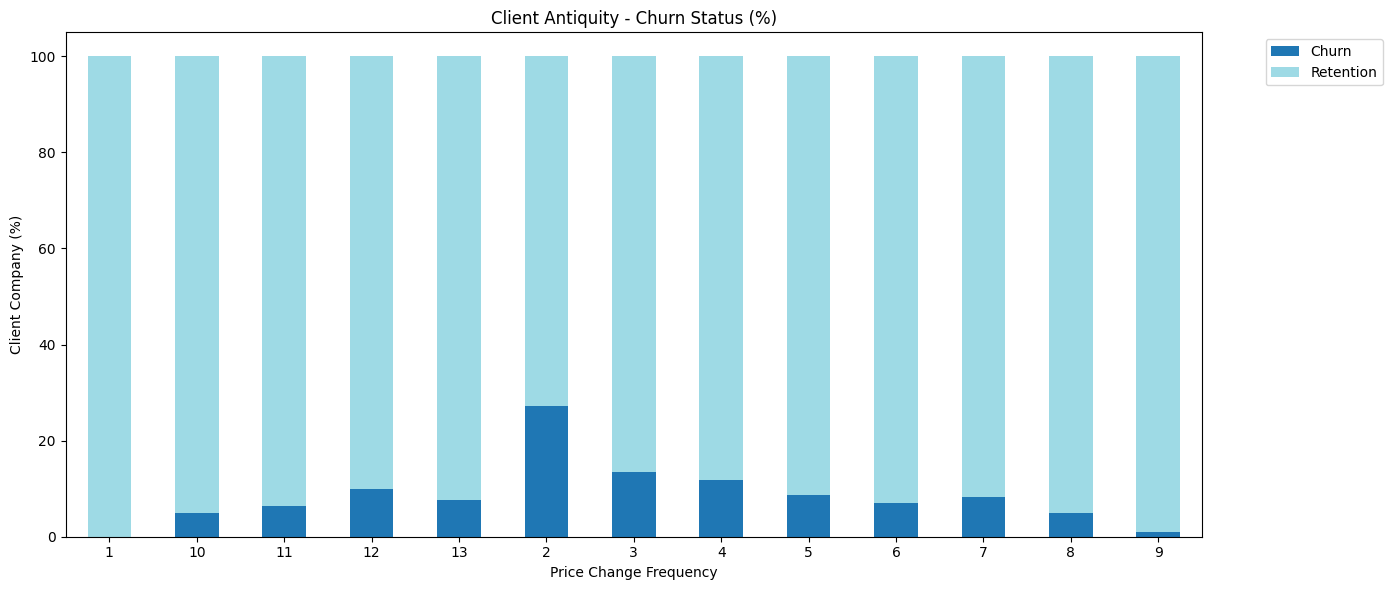

In [57]:
stacked_bar_percent(client_df, 'num_years_antig', 'churn', 'Client Antiquity - Churn Status (%)', 'Price Change Frequency', 'Client Company', agg_method='count',rotation=0)


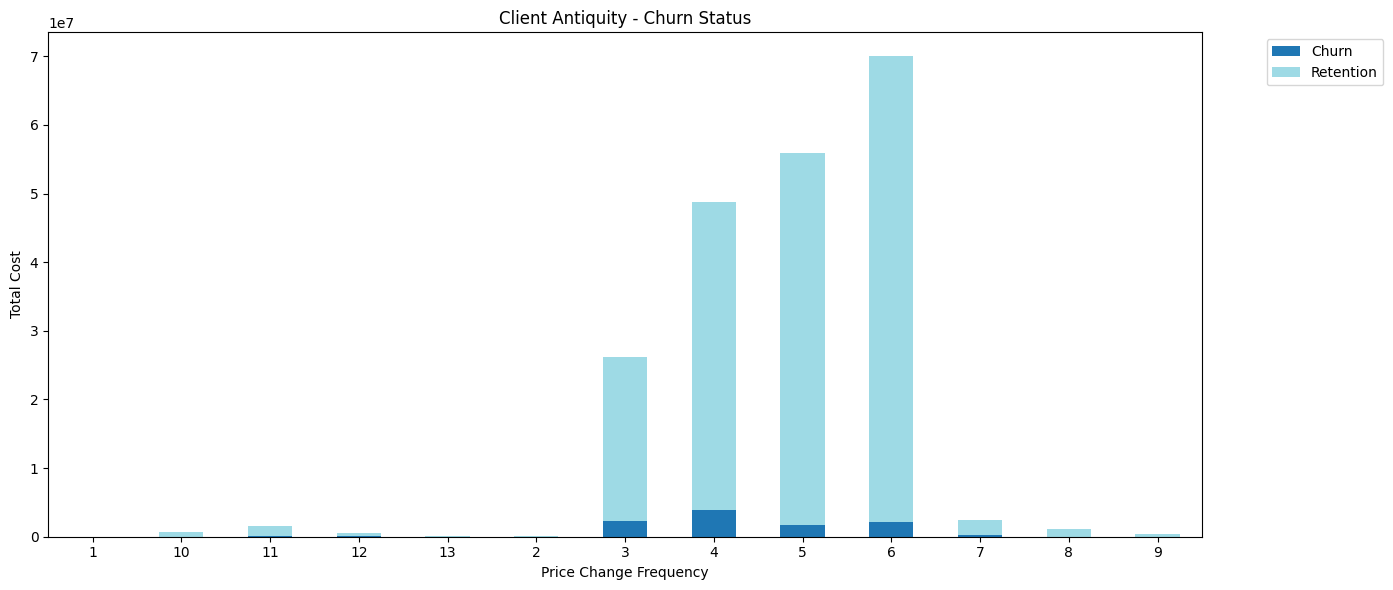

In [58]:
stacked_bar(client_df, 'num_years_antig', 'churn' ,'Client Antiquity - Churn Status', 'Price Change Frequency', 'Total Cost', agg_method='sum',rotation=0,value='estimated_total_cost_last_12m')


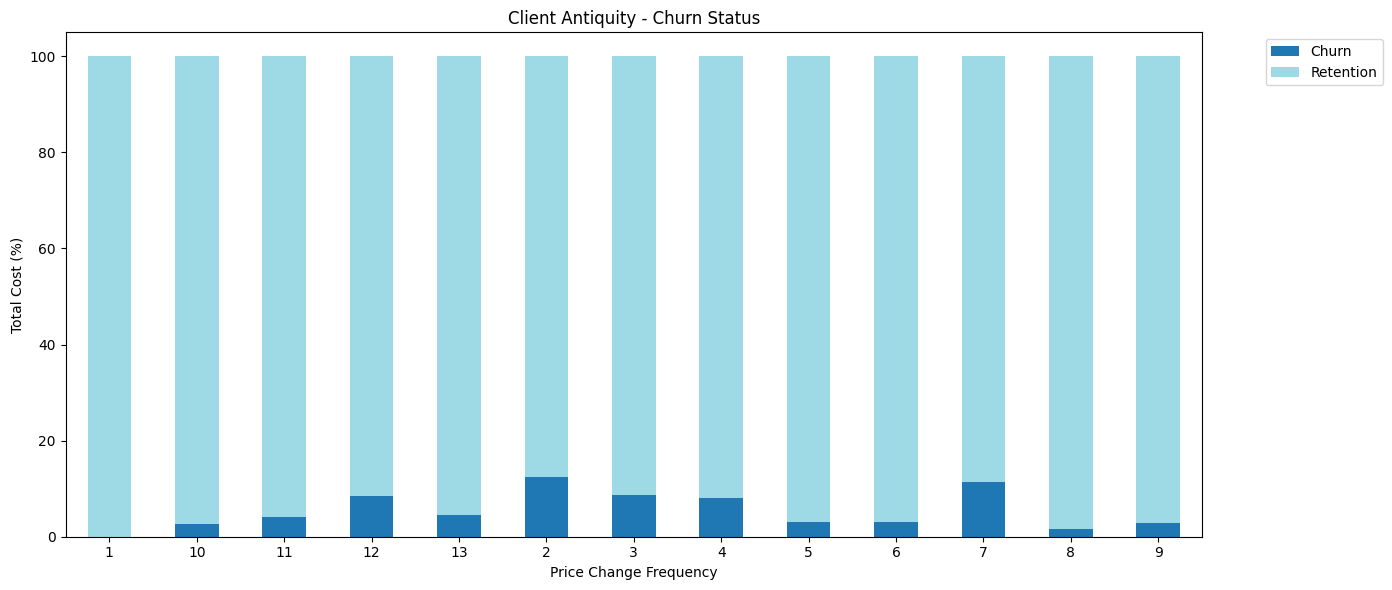

In [59]:
stacked_bar_percent(client_df, 'num_years_antig', 'churn' ,'Client Antiquity - Churn Status', 'Price Change Frequency', 'Total Cost', agg_method='sum',rotation=0,value='estimated_total_cost_last_12m')


#### Summary Dashboard

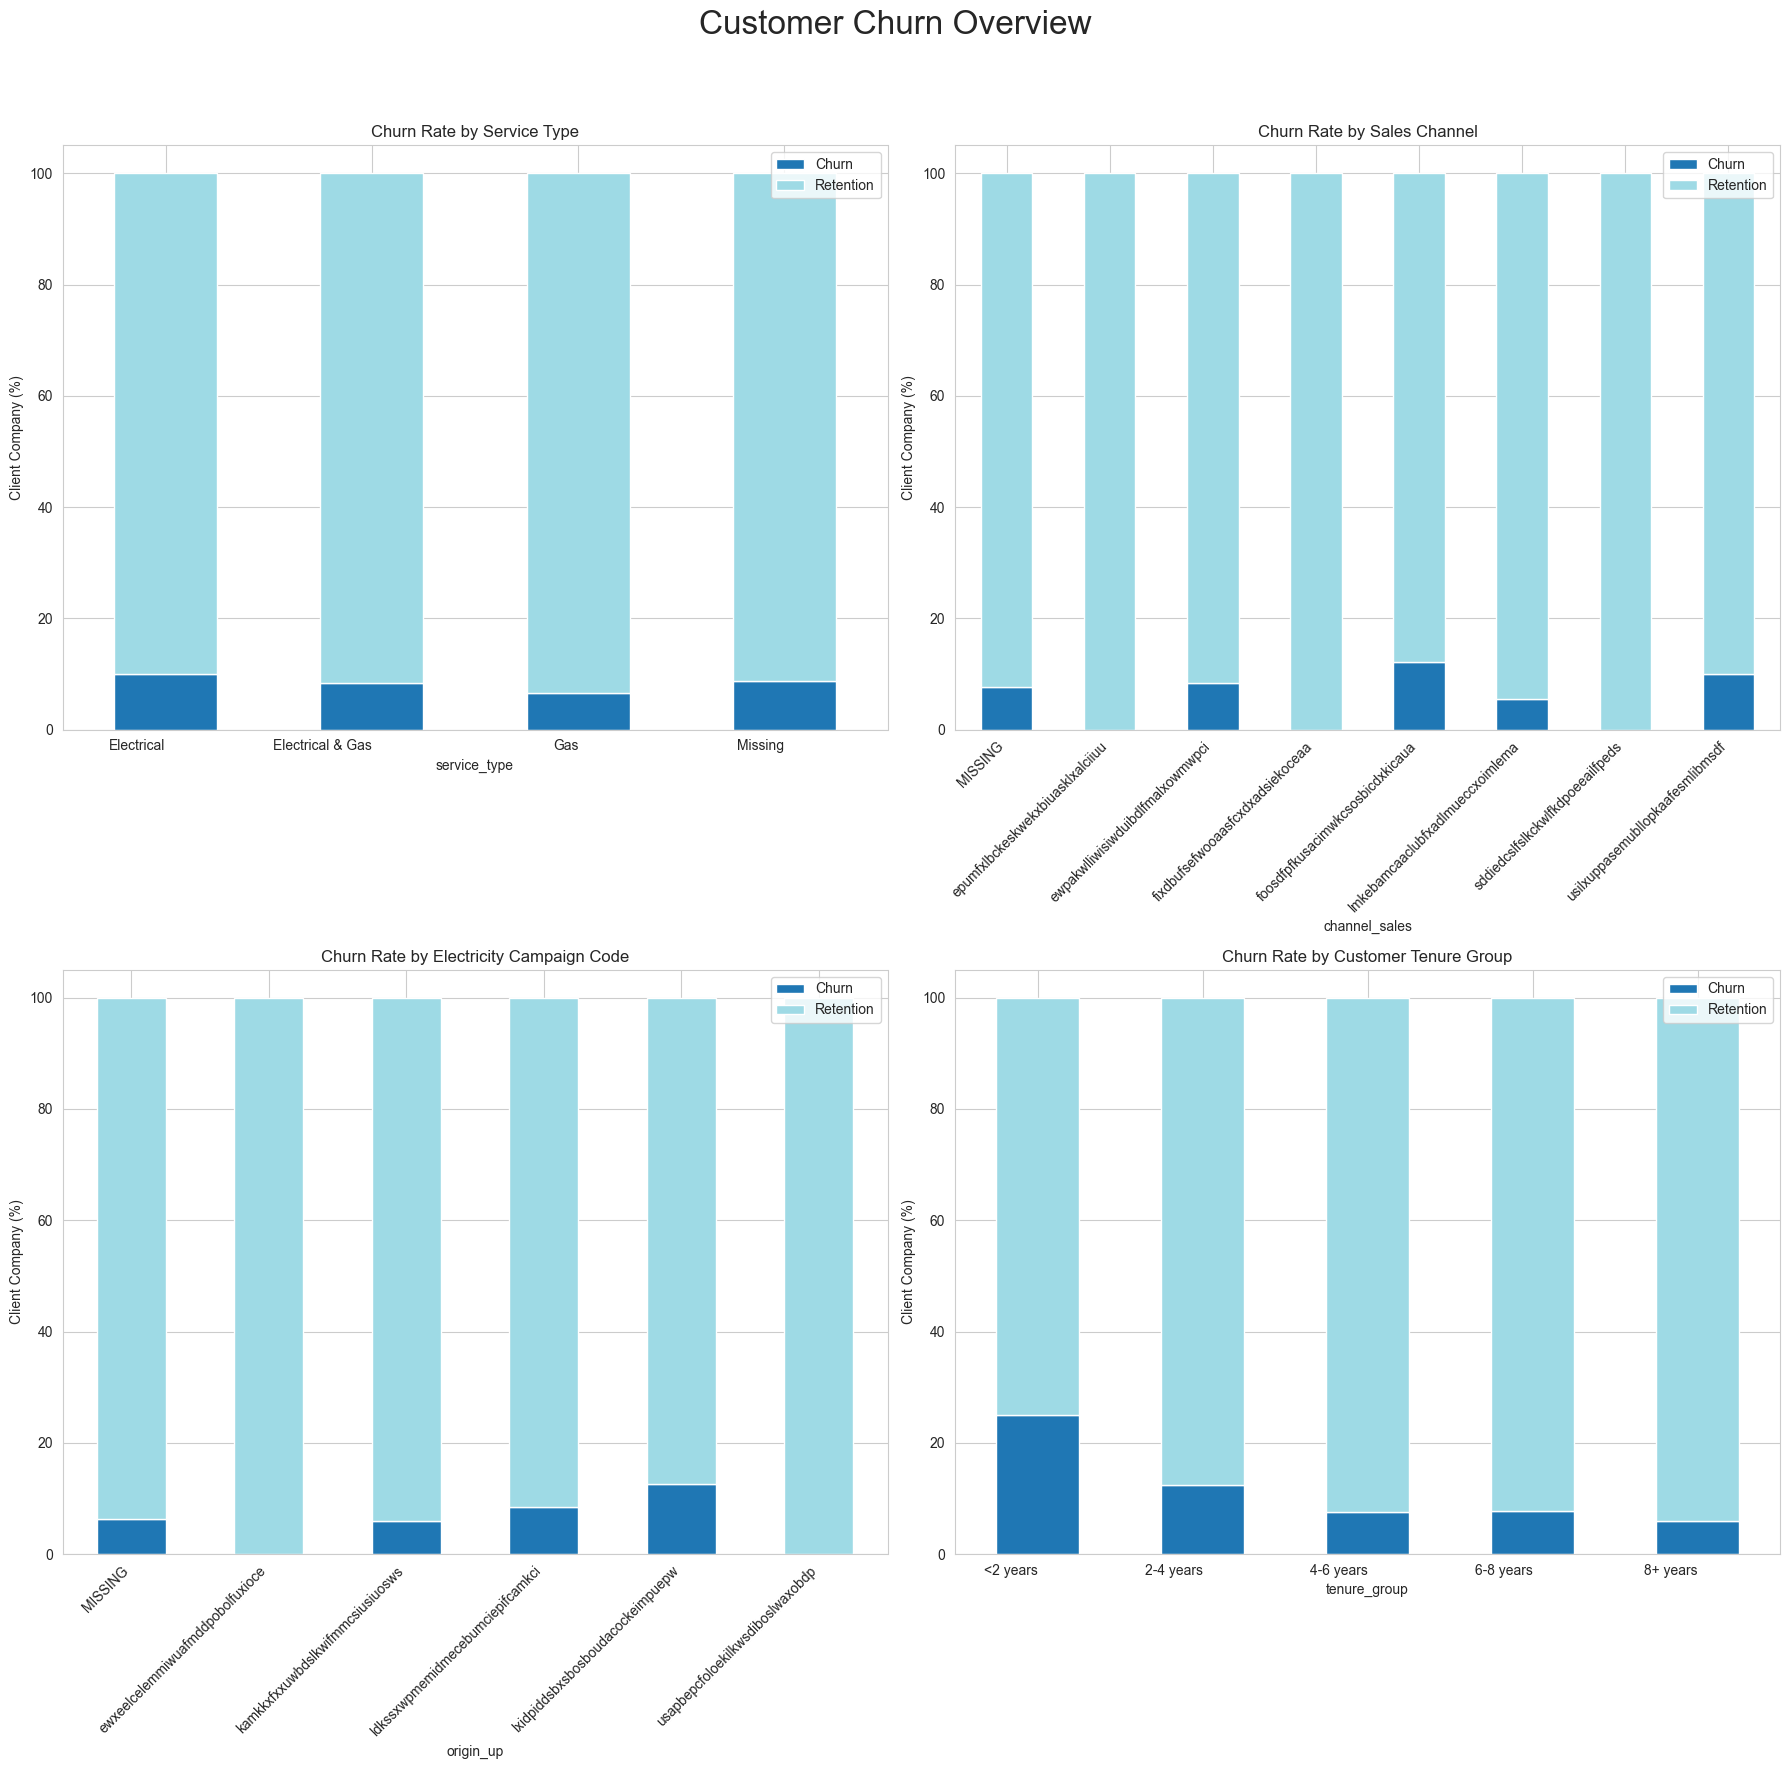

In [60]:
sns.set_style('whitegrid')

fig, axs = plt.subplots(2, 2, figsize=(18, 18))

service_type_churn = pd.crosstab(client_df['service_type'], client_df['churn'], normalize='index') * 100
service_type_churn.plot(kind='bar', stacked=True, ax=axs[0, 0], colormap='tab20')
axs[0, 0].set_title('Churn Rate by Service Type')
axs[0, 0].set_ylabel('Client Company (%)')
axs[0, 0].legend(title='')
axs[0, 0].set_xticklabels(axs[0, 0].get_xticklabels(), rotation=0, ha='right')


channel_sales_churn = pd.crosstab(client_df['channel_sales'], client_df['churn'], normalize='index') * 100
channel_sales_churn.plot(kind='bar', stacked=True, ax=axs[0, 1], colormap='tab20')
axs[0, 1].set_title('Churn Rate by Sales Channel')
axs[0, 1].set_ylabel('Client Company (%)')
axs[0, 1].legend(title='')
axs[0, 1].set_xticklabels(axs[0, 1].get_xticklabels(), rotation=45, ha='right')

origin_churn = pd.crosstab(client_df['origin_up'], client_df['churn'], normalize='index') * 100
origin_churn.plot(kind='bar', stacked=True, ax=axs[1, 0], colormap='tab20')
axs[1, 0].set_title('Churn Rate by Electricity Campaign Code')
axs[1, 0].set_ylabel('Client Company (%)')
axs[1, 0].legend(title='')
axs[1, 0].set_xticklabels(axs[1, 0].get_xticklabels(), rotation=45, ha='right')

client_df['num_years_antig'] = pd.to_numeric(client_df['num_years_antig'], errors='coerce')
bins = [0, 2, 4, 6, 8, 15]
labels = ['<2 years', '2-4 years', '4-6 years', '6-8 years','8+ years']
client_df['tenure_group'] = pd.cut(client_df['num_years_antig'], bins=bins, labels=labels)

tenure_churn = pd.crosstab(client_df['tenure_group'], client_df['churn'], normalize='index') * 100
tenure_churn.plot(kind='bar', stacked=True, ax=axs[1, 1], colormap='tab20')
axs[1, 1].set_title('Churn Rate by Customer Tenure Group')
axs[1, 1].set_ylabel('Client Company (%)')
axs[1, 1].legend(title='')
axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), rotation=0, ha='right')


plt.suptitle('Customer Churn Overview', fontsize=24)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


**_Key Observations_**:
- Significant portion of the customer base is concentrated at lower annual electricity costs, specifically below $25,000. However, churned customers tend to skew toward higher cost brackets, indicating that **_cost sensitivity is a key driver of customer churn_***.
- The overall net churn rate is 9.7%. Customers with 2–4 years of tenure demonstrate a higher churn rate at 12.5%, whereas customers with over 8 years of tenure show strong loyalty, with churn falling to just 6%. This suggests that tenure is a critical factor in customer retention.
- Approximately 25% of customers (3,725 customers) are associated with **_MISSING_** sales channels, where the churn rate stands at 7.6%. This may be attributed to gaps in onboarding and early customer engagement processes.
- Customers enrolled in the **_Electrical_** service type account for 81% of the total customer base (11,892 customers) and exhibit a churn rate of 9.9%. Notably, customers subscribed to both **_Electrical & Gas_** services experience a lower churn rate of 8.5%, highlighting the retention benefits of offering multiple services.
- Analysis by Electrical campaign indicates that customers acquired through campaign code **_lxidpiddsbxsbosboudacockeimpuepw_** (7,097 customers) exhibit a churn rate of 12.6%, which is higher than the overall average.
- Similarly, customers acquired through the sales channel **_foosdfpfkusacimwkcsosbicdxkicaua_** (6,754 customers) have a churn rate of 12.1%, suggesting that certain acquisition channels may contribute disproportionately to customer turnover

## Feature Engineering

### Functions

In [61]:
def plot_box_whisker(df, numeric_fields, ncols=3, figsize=(18, 10)):
    n_rows = (len(numeric_fields) + ncols - 1) // ncols
    fig, axes = plt.subplots(nrows=n_rows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for idx, field in enumerate(numeric_fields):
        sns.boxplot(data=df, y=field, ax=axes[idx])
        axes[idx].set_title(f'Boxplot of {field}')
        axes[idx].grid(True)

    for j in range(idx + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

In [62]:
def cap_outliers(df, features):
    for feature in features:
        lower_cap = df[feature].quantile(0.01)
        upper_cap = df[feature].quantile(0.99)
        df[feature] = df[feature].clip(lower=lower_cap, upper=upper_cap)
    return df

### Data Loading

In [63]:
df = pd.read_csv('Data/clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14606 entries, 0 to 14605
Data columns (total 44 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   id                              14606 non-null  object        
 1   channel_sales                   14606 non-null  object        
 2   cons_12m                        14606 non-null  int64         
 3   cons_gas_12m                    14606 non-null  int64         
 4   cons_last_month                 14606 non-null  int64         
 5   date_activ                      14606 non-null  datetime64[ns]
 6   date_end                        14606 non-null  datetime64[ns]
 7   date_modif_prod                 14606 non-null  datetime64[ns]
 8   date_renewal                    14606 non-null  datetime64[ns]
 9   forecast_cons_12m               14606 non-null  float64       
 10  forecast_cons_year              14606 non-null  int64         
 11  fo

In [65]:
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,num_years_antig,origin_up,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,0,0.0,1.78,0.114481,0.098142,40.606701,t,0.00,25.44,25.44,2,678.99,3,lxidpiddsbxsbosboudacockeimpuepw,43.648,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,0,0.0,16.27,0.145711,0.000000,44.311378,f,0.00,16.38,16.38,1,18.89,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.800,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,0,0.0,38.72,0.165794,0.087899,44.311378,f,0.00,28.60,28.60,1,6.60,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.856,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,0,0.0,19.83,0.146694,0.000000,44.311378,f,0.00,30.22,30.22,1,25.46,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,13.200,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,526,0.0,131.73,0.116900,0.100015,40.606701,f,52.32,44.91,44.91,1,47.98,6,kamkkxfxxuwbdslkwifmmcsiusiuosws,19.800,0.000015,3.552481e-06,0.000003,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0


In [66]:
price_df = pd.read_csv('Data/price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')
price_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 193002 entries, 0 to 193001
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   id                  193002 non-null  object        
 1   price_date          193002 non-null  datetime64[ns]
 2   price_off_peak_var  193002 non-null  float64       
 3   price_peak_var      193002 non-null  float64       
 4   price_mid_peak_var  193002 non-null  float64       
 5   price_off_peak_fix  193002 non-null  float64       
 6   price_peak_fix      193002 non-null  float64       
 7   price_mid_peak_fix  193002 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 11.8+ MB


### Feature engineering

#### Pricing Sensitivity

In [67]:
# Difference between off-peak prices in December & preceding January
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({'price_off_peak_var': 'mean', 'price_off_peak_fix': 'mean'}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={'price_off_peak_var': 'price_off_peak_var_dec', 'price_off_peak_fix': 'price_off_peak_fix_dec'}), jan_prices.drop(columns='price_date'), on='id')
diff['offpeak_diff_dec_january_energy'] = diff['price_off_peak_var_dec'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['price_off_peak_fix_dec'] - diff['price_off_peak_fix']
diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power']]

df = pd.merge(df,diff,on='id',how='left')
df.shape

(14606, 46)

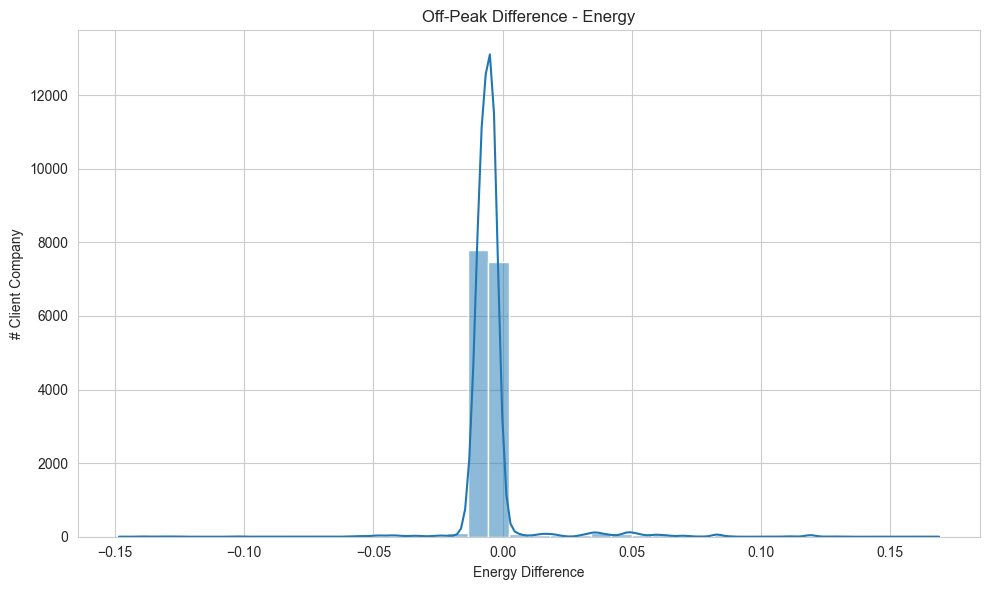

In [68]:
histogram(diff, "offpeak_diff_dec_january_energy", 40, "Off-Peak Difference - Energy", "Energy Difference", "# Client Company",kde=True)

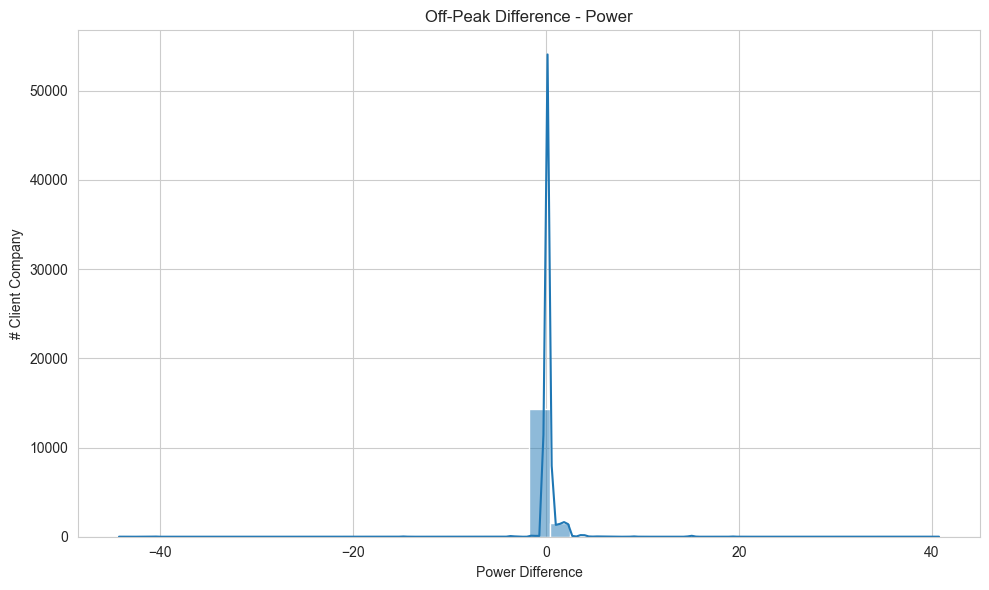

In [69]:
histogram(diff, "offpeak_diff_dec_january_power", 40, "Off-Peak Difference - Power", "Power Difference", "# Client Company",kde=True)

**_Assumption_**: cons_last_month is split equally across 3 periods.
- 1/3rd of cons_last_month → Off-Peak usage
- 1/3rd of cons_last_month → Mid-Peak usage
- 1/3rd of cons_last_month → Peak usage

In [70]:
df= pd.merge(df,price_dec_2015,on='id',how='left')
df.shape

(14606, 54)

In [71]:
df['consumption_off_peak_dec_2015'] = df['cons_last_month'] / 3
df['consumption_mid_peak_dec_2015'] = df['cons_last_month'] / 3
df['consumption_peak_dec_2015'] = df['cons_last_month'] / 3

df['cost_off_peak_dec_2015'] = (df['consumption_off_peak_dec_2015'] * df['price_off_peak_var']) + df['price_off_peak_fix']
df['cost_mid_peak_dec_2015'] = (df['consumption_mid_peak_dec_2015'] * df['price_mid_peak_var']) + df['price_mid_peak_fix']
df['cost_peak_dec_2015'] = (df['consumption_peak_dec_2015'] * df['price_peak_var']) + df['price_peak_fix']

df['estimated_total_cost_dec_2015'] = df['cost_off_peak_dec_2015'] + df['cost_mid_peak_dec_2015'] + df['cost_peak_dec_2015']

df.groupby('churn')[['cons_last_month','estimated_total_cost_dec_2015']].sum()


,cons_last_month,estimated_total_cost_dec_2015
churn,,
0,224790245,1.979169e+07
1,10224235,9.391050e+05


**_Assumption_**: cons_12m is equally split across months and across time periods (off/mid/peak)

In [72]:
df['consumption_per_month'] = df['cons_12m'] / 12

df['consumption_off_peak_month'] = df['consumption_per_month'] / 3
df['consumption_mid_peak_month'] = df['consumption_per_month'] / 3
df['consumption_peak_month'] = df['consumption_per_month'] / 3

price_expanded_df = price_df.merge(df[['id', 'consumption_off_peak_month', 'consumption_mid_peak_month', 'consumption_peak_month']], on='id', how='left')

price_expanded_df['monthly_cost_off_peak'] = (price_expanded_df['consumption_off_peak_month'] * price_expanded_df['price_off_peak_var']) + price_expanded_df['price_off_peak_fix']
price_expanded_df['monthly_cost_mid_peak'] = (price_expanded_df['consumption_mid_peak_month'] * price_expanded_df['price_mid_peak_var']) + price_expanded_df['price_mid_peak_fix']
price_expanded_df['monthly_cost_peak'] = (price_expanded_df['consumption_peak_month'] * price_expanded_df['price_peak_var']) + price_expanded_df['price_peak_fix']

price_expanded_df['total_monthly_cost'] = price_expanded_df['monthly_cost_off_peak'] + price_expanded_df['monthly_cost_mid_peak'] + price_expanded_df['monthly_cost_peak']

In [73]:
total_12m_cost = price_expanded_df.groupby('id')['total_monthly_cost'].sum().reset_index()
total_12m_cost = total_12m_cost.rename(columns={'total_monthly_cost': 'estimated_total_cost_last_12m'})

df = df.merge(total_12m_cost, on='id', how='left')
df.groupby('churn')[['cons_12m','estimated_total_cost_last_12m']].sum()

,cons_12m,estimated_total_cost_last_12m
churn,,
0,2213665644,1.973086e+08
1,111905857,1.045486e+07


In [74]:
# price_peak_var_mean
price_peak_mean = price_df.groupby('id')['price_peak_var'].mean().reset_index(name='price_peak_var_mean')

df = pd.merge(df,price_peak_mean, on='id', how='left')
df.shape

(14606, 67)

In [75]:
# Price Change Change - 1 month
df['price_change_1m']= df['estimated_total_cost_dec_2015']/(df['estimated_total_cost_last_12m']/12)

In [76]:
# Price Change Frequency
price_df = price_df.sort_values(['id', 'price_date'])
price_df['prev_price'] = price_df.groupby('id')['price_off_peak_var'].shift(1)
price_df['price_changed'] = (price_df['price_off_peak_var'] != price_df['prev_price']).astype(int)
price_change_frequency = price_df.groupby('id')['price_changed'].sum().reset_index()
price_change_frequency = price_change_frequency.rename(columns={'price_changed': 'price_change_frequency'})
df = pd.merge(df,price_change_frequency, on='id', how='left')
df.shape

(14606, 69)

#### Consumption Behavior & Service Attributes

In [77]:
# Replacing 0 with Null for cons_12m and cons_gas_12m
df[['cons_12m','cons_gas_12m']] = df[['cons_12m','cons_gas_12m']].astype(int)
df[['cons_12m','cons_gas_12m']] = df[['cons_12m','cons_gas_12m']].replace(0, np.nan)

In [78]:
# Has Gas field -> Binary
df['has_gas'] = df['has_gas'].replace({'t': 1, 'f': 0})

**_Service Type_**:
- 0 -> Missing
- 1 -> Electrical
- 2 -> Electrical & Gas
- 3 -> Gas


In [79]:
conditions = [
    df['cons_12m'].notna() & df['cons_gas_12m'].isna(),
    df['cons_12m'].notna() & df['cons_gas_12m'].notna(),
    df['cons_12m'].isna() & df['cons_gas_12m'].notna(),
    df['cons_12m'].isna() & df['cons_gas_12m'].isna()
]
choices = [1,2,3,0]
df['service_type'] = np.select(conditions, choices, default=0)
df['service_type'].value_counts()

service_type
1    11892
2     2597
0      102
3       15
Name: count, dtype: int64

In [80]:
# Replacing 0 with Null for cons_last_month
condition = (df['service_type'].isin([3,4])) & (df['cons_last_month'] == 0)
df.loc[condition, 'cons_last_month'] = np.nan

In [81]:
# Consumption Change - 1 month
df['cons_change_1m']= df['cons_last_month']/(df['cons_12m']/12)

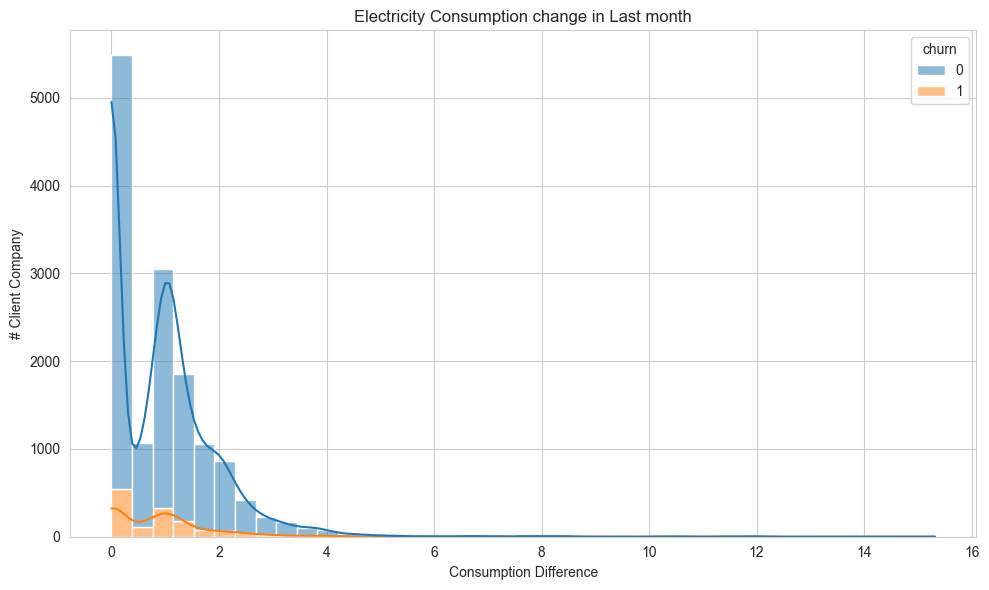

In [82]:
histogram(df, "cons_change_1m", 40, "Electricity Consumption change in Last month", "Consumption Difference", "# Client Company", "churn" ,kde=True)

#### Customer Tenure and Engagement

In [83]:
# Encode Categorical Fields
le = LabelEncoder()

df['channel_sales_encoded'] = le.fit_transform(df['channel_sales'].astype(str))
df['origin_up_encoded'] = le.fit_transform(df['origin_up'].astype(str))

**_Customer Tenure_**:
- 0 -> <2 years 
- 1 -> 2-4 years
- 2 -> 4-6 years
- 3 -> 6-8 years
- 4 -> 8+ years

In [84]:
df['num_years_antig'] = pd.to_numeric(df['num_years_antig'], errors='coerce')
bins = [0, 2, 4, 6, 8, 15]
labels = [0, 1, 2, 3, 4]
df['Customer_Tenure'] = pd.cut(df['num_years_antig'], bins=bins, labels=labels)

In [85]:
df['nb_prod_act'].value_counts().to_dict()

{1: 11431, 2: 2445, 3: 523, 4: 150, 5: 31, 9: 11, 6: 8, 8: 4, 10: 2, 32: 1}

#### Days Until Contract Termination (Reference: 2016-01-29)

**_Observation_**: latest date available in df -> 2016-01-29 (field: date_modif_prod)

In [86]:
reference_date = pd.to_datetime('2016-01-29')
df['days_until_contract_end'] = (df['date_end'] - reference_date).dt.days

### Handling Fields with Outilers & Removing unnecessary fields

In [87]:
columns_to_remove = [
    'price_date',
    'date_activ',
    'date_modif_prod',
    'date_renewal',
    'date_end',
    'consumption_per_month',
    'consumption_off_peak_month',
    'consumption_mid_peak_month',
    'consumption_peak_month',
    'consumption_off_peak_dec_2015',
    'consumption_mid_peak_dec_2015',
    'consumption_peak_dec_2015',
    'cost_off_peak_dec_2015',
    'cost_mid_peak_dec_2015',
    'cost_peak_dec_2015',
]

In [88]:
columns_for_outlier_removal = [
    'cons_12m',
    'cons_last_month',
    'cons_change_1m',
    'forecast_cons_12m',
    'forecast_cons_year',
    'forecast_discount_energy',
    'forecast_meter_rent_12m',
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak',
    'forecast_price_pow_off_peak',
    'estimated_total_cost_last_12m',
    'estimated_total_cost_dec_2015',
    'price_peak_var_mean',
    'price_change_1m',
    'days_until_contract_end',
    'pow_max',
    'margin_gross_pow_ele',
    'margin_net_pow_ele',
    'net_margin',
    'var_year_price_off_peak_var',
    'var_year_price_peak_var',
    'var_year_price_mid_peak_var',
    'var_year_price_off_peak_fix',
    'var_year_price_peak_fix',
    'var_year_price_mid_peak_fix',
    'var_year_price_off_peak',
    'var_year_price_peak',
    'var_year_price_mid_peak',
    'var_6m_price_off_peak_var',
    'var_6m_price_peak_var',
    'var_6m_price_mid_peak_var',
    'var_6m_price_off_peak_fix',
    'var_6m_price_peak_fix',
    'var_6m_price_mid_peak_fix',
    'var_6m_price_off_peak',
    'var_6m_price_peak',
    'var_6m_price_mid_peak',
    'offpeak_diff_dec_january_energy',
    'offpeak_diff_dec_january_power'
]


In [89]:
df = df.drop(columns=columns_to_remove)

df = cap_outliers(df, columns_for_outlier_removal)

#### Box & Wisker plot

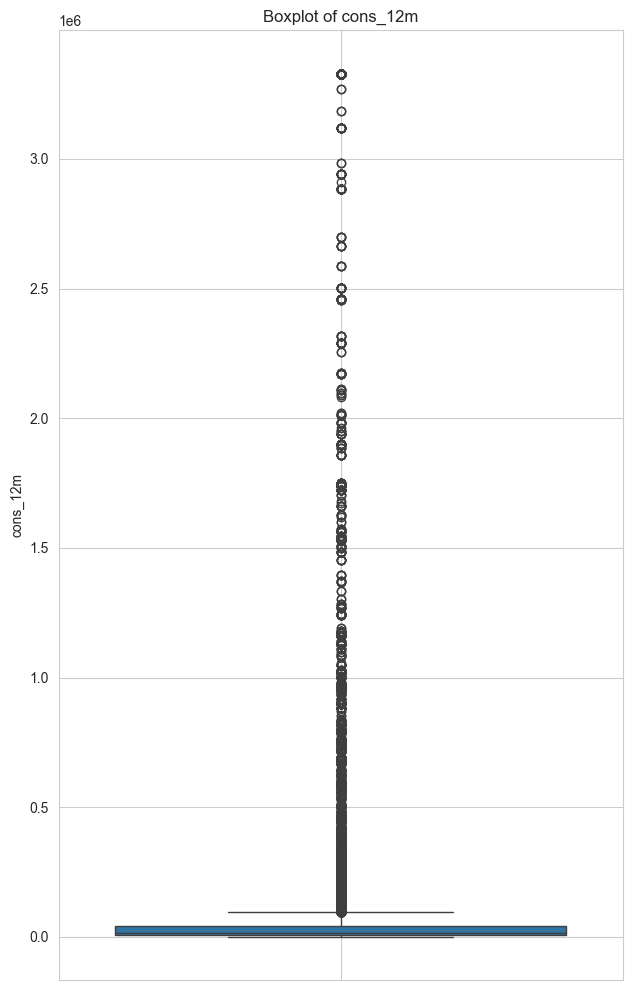

In [90]:
plot_box_whisker(df, ['cons_12m'])

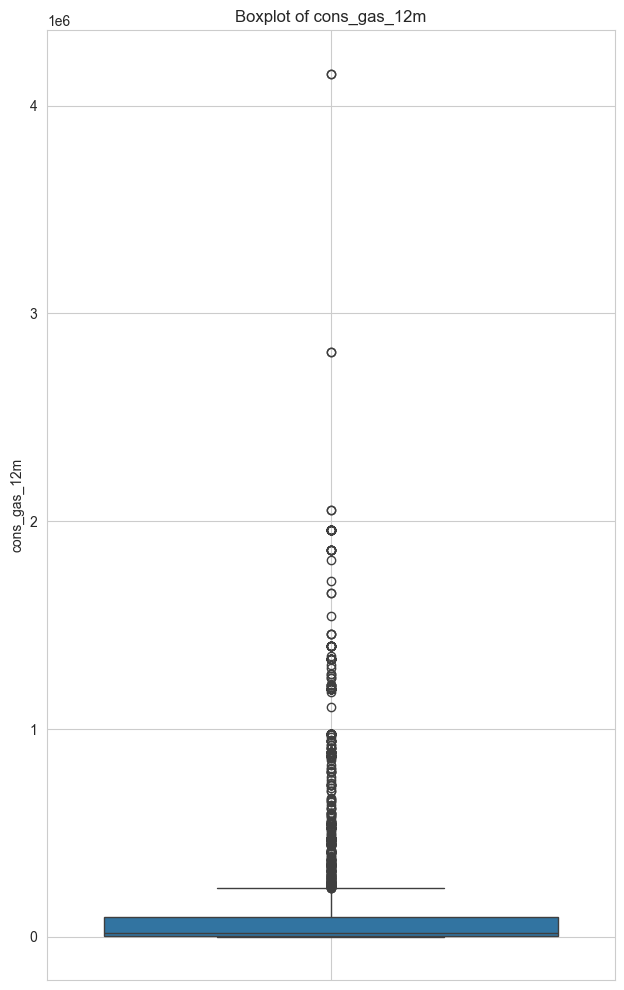

In [91]:
plot_box_whisker(df, ['cons_gas_12m'])

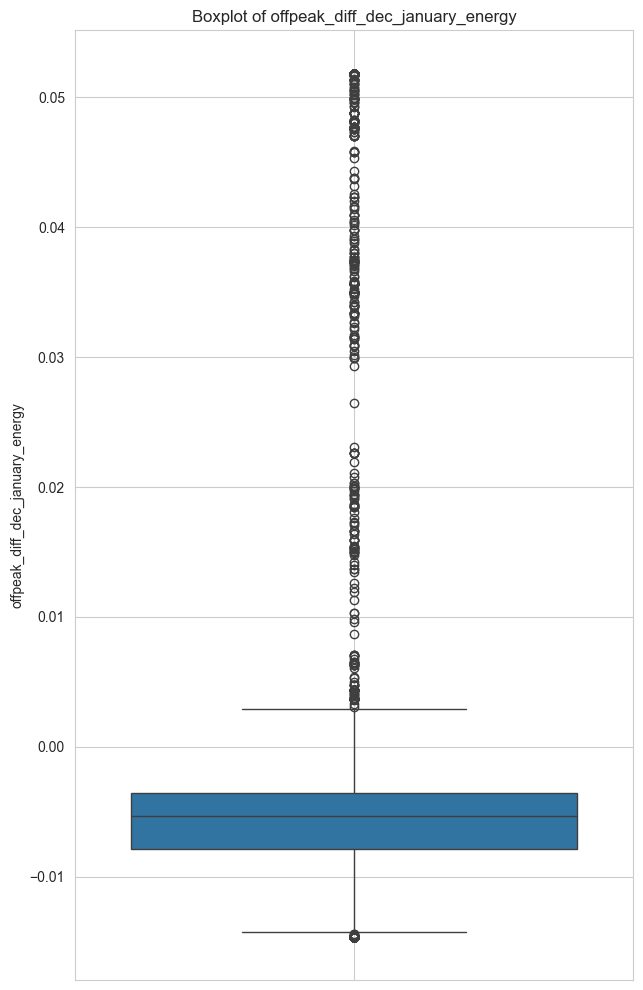

In [92]:
plot_box_whisker(df, ['offpeak_diff_dec_january_energy'])

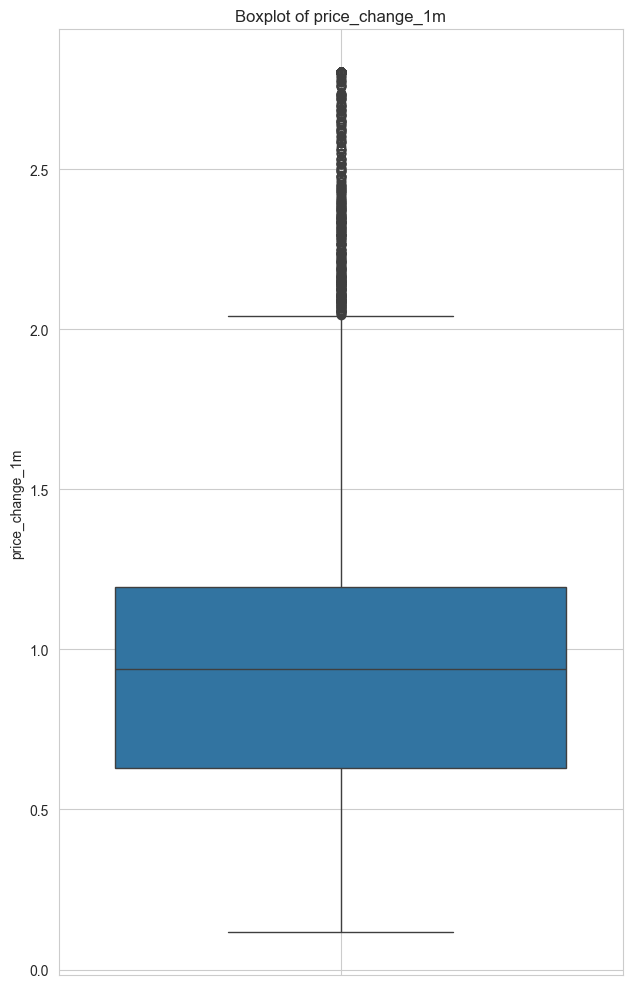

In [93]:
plot_box_whisker(df, ['price_change_1m'])

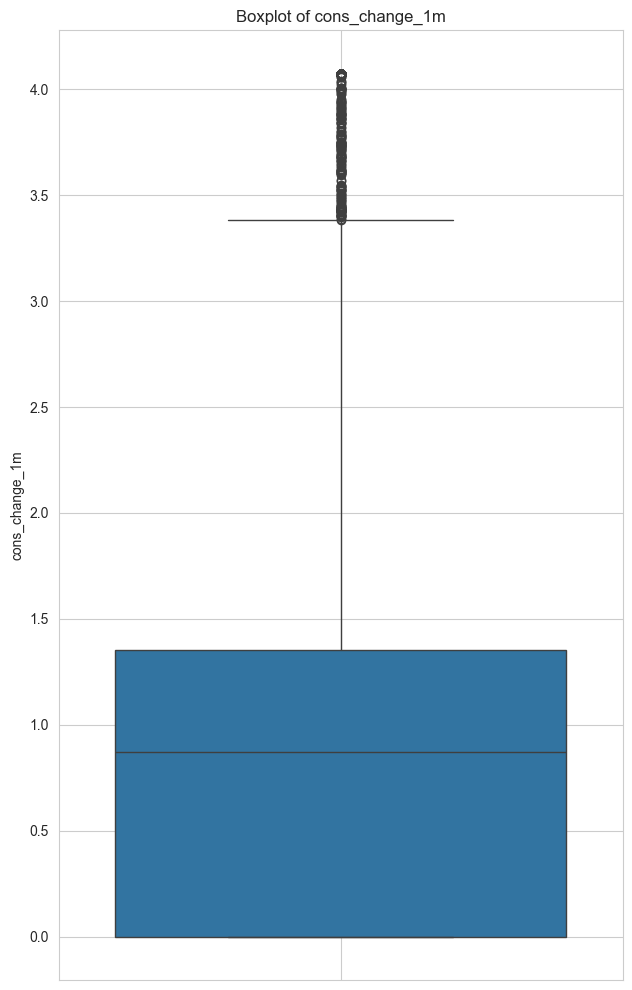

In [94]:
plot_box_whisker(df, ['cons_change_1m'])

### Summary

**_1. Feature Engineering_**

- **Consumption Features:**
  - `cons_12m`, `cons_last_month`, `cons_change_1m`: Capture total and recent consumption trends.

- **Pricing Sensitivity Features:**
  - `estimated_total_cost_last_12m`: Total electricity cost over the last 12 months.
  - `offpeak_diff_dec_january_energy`: Change in off-peak variable energy price between Dec and Jan.
  - `offpeak_diff_dec_january_power`: Change in off-peak fixed power price between Dec and Jan.
  - `price_peak_var_mean`: Average peak price experienced over the year.

- **Price Volatility Features:**
  - `var_year_price_*` and `var_6m_price_*`: Price variation over past 12 months and past 6 months across off-peak, mid-peak, and peak periods (both variable and fixed).

- **Engagement and Loyalty Features:**
  - `nb_prod_act`: Number of active products.
  - `has_gas`: Whether the customer has a gas product.
  - `Customer_Tenure`: Tenure bucket derived from `num_years_antig`.
  - `days_until_contract_end`: Number of days left before contract expiration (calculated relative to 2016-01-29).

- **Acquisition and Channel Features:**
  - `channel_sales_encoded`, `origin_up_encoded`: Encoded fields representing sales and marketing origin.

- **Price Change Behavior:**
  - `price_change_1m`: Recent month price change.
  - `price_change_frequency`: Number of price changes during the last 12 months.

---

**_2. Outlier Handling_**

- **Initial Approach:**
  - Outliers were first identified using the **IQR (Interquartile Range) method**.
  - However, direct removal of outliers led to a sharp drop in data volume (from ~14k rows to ~2.3k rows).

- **Final Approach:** To preserve customer diversity and data volume, we applied **Winsorization (Capping)**
    - Capped all numerical features at the **1st and 99th percentiles**.
    - Preserved ~100% of the customer base while limiting the impact of extreme values.

## Churn Prediction

### Data Loading

In [95]:
df = pd.read_csv('Data/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,has_gas,imp_cons,margin_gross_pow_ele,margin_net_pow_ele,nb_prod_act,net_margin,pow_max,var_year_price_off_peak_var,var_year_price_peak_var,var_year_price_mid_peak_var,var_year_price_off_peak_fix,var_year_price_peak_fix,var_year_price_mid_peak_fix,var_year_price_off_peak,var_year_price_peak,var_year_price_mid_peak,var_6m_price_off_peak_var,var_6m_price_peak_var,var_6m_price_mid_peak_var,var_6m_price_off_peak_fix,var_6m_price_peak_fix,var_6m_price_mid_peak_fix,var_6m_price_off_peak,var_6m_price_peak,var_6m_price_mid_peak,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,off_peak_peak_var_mean_diff,peak_mid_peak_var_mean_diff,off_peak_mid_peak_var_mean_diff,off_peak_peak_fix_mean_diff,peak_mid_peak_fix_mean_diff,off_peak_mid_peak_fix_mean_diff,off_peak_peak_var_max_monthly_diff,peak_mid_peak_var_max_monthly_diff,off_peak_mid_peak_var_max_monthly_diff,off_peak_peak_fix_max_monthly_diff,peak_mid_peak_fix_max_monthly_diff,off_peak_mid_peak_fix_max_monthly_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_MISSING,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,origin_up_lxidpiddsbxsbosboudacockeimpuepw
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,40.606701,1,0.00000,25.44,25.44,2,678.99,43.648,0.000061,2.627605e-05,0.000440,1.102785,49.550703,22.022535,1.102846,4.955073e+01,22.022975,0.000131,4.100838e-05,9.084737e-04,2.086294,99.530517,44.235794,2.086425,9.953056e+01,4.423670e+01,1,0.020057,3.700961,0.024038,0.034219,0.058257,18.590255,7.450670,26.040925,0.060550,0.085483,0.146033,44.266930,8.145775,44.26693,3,30,5,2,6,0,0,1,0,0,0,0,1
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.0,1.237292,0.145711,0.000000,44.311378,0,0.00000,16.38,16.38,1,18.89,13.800,0.000005,6.089453e-04,0.000000,0.006465,0.000000,0.000000,0.006470,6.089453e-04,0.000000,0.000003,1.217891e-03,0.000000e+00,0.009482,0.000000,0.000000,0.009485,1.217891e-03,0.000000e+00,0,-0.003767,0.177779,0.142485,0.007124,0.149609,44.311375,0.000000,44.311375,0.151367,0.085483,0.151367,44.444710,0.000000,44.44471,7,76,7,76,4,1,0,0,0,0,1,0,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.0,1.599009,0.165794,0.087899,44.311378,0,0.00000,28.60,28.60,1,6.60,13.856,0.000006,2.558511e-07,0.000000,0.007662,0.000000,0.000000,0.007668,2.558511e-07,0.000000,0.000004,9.450150e-08,0.000000e+00,0.000000,0.000000,0.000000,0.000004,9.450150e-08,0.000000e+00,0,-0.004670,0.177779,0.082090,0.088421,0.170512,44.385450,0.000000,44.385450,0.084587,0.089162,0.172468,44.444710,0.000000,44.44471,6,68,3,68,8,0,0,1,0,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.0,1.318689,0.146694,0.000000,44.311378,0,0.00000,30.22,30.22,1,25.46,13.200,0.000005,0.000000e+00,0.000000,0.006465,0.000000,0.000000,0.006470,0.000000e+00,0.000000,0.000003,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000003,0.000000e+00,0.000000e+00,0,-0.004547,0.177779,0.151210,0.000000,0.151210,44.400265,0.000000,44.400265,0.153133,0.000000,0.153133,44.444710,0.000000,44.44471,6,69,2,69,9,0,0,0,1,0,1,0,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,0.0,2.122969,0.116900,0.100015,40.606701,0,1.72689,44.91,44.91,1,47.98,19.800,0.000015,3.552481e-06,0.000003,0.005429,0.001954,0.000869,0.005444,1.957971e-03,0.000871,0.000011,2.896760e-06,4.860000e-10,0.000000,0.000000,0.000000,0.000011,2.896760e-06,4.860000e-10,0,-0.006192,0.162916,0.020536,0.030773,0.051309,16.275263,8.137629,24.412893,0.022225,0.033743,0.055866,16.291555,8.145775

### Modelling

In [96]:
train_df = df.copy()

y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)

(14606, 61)
(14606,)


In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10954, 61)
(10954,)
(3652, 61)
(3652,)


### Model training

In [98]:
params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']
}

In [99]:
grid = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=params,
    cv=3,
    scoring={
        'roc_auc': 'roc_auc',
        'recall': make_scorer(recall_score)
    },
    refit='recall',
    n_jobs=-1,
    verbose=2
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

Fitting 3 folds for each of 1620 candidates, totalling 4860 fits
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   2.2s
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   2.0s
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.7s
[CV] END bootstrap=True, class_weight=balanced, max_depth=5, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=5, max_features='log2', min_samples_split=5)

In [100]:
best_model

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=5, max_features='log2', min_samples_split=5)

In [110]:
#roc_auc -> rf = RandomForestClassifier(class_weight='balanced_subsample', max_features='log2',min_samples_leaf=4, n_estimators=200)
rf = RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample', max_depth=5, max_features='log2', min_samples_split=5)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, class_weight='balanced_subsample',
                       max_depth=5, max_features='log2', min_samples_split=5)

### Evaluation

In [111]:
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

In [112]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6722343921139102
ROC AUC Score: 0.6415081867435619
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.69      0.79      3286
           1       0.16      0.55      0.25       366

    accuracy                           0.67      3652
   macro avg       0.55      0.62      0.52      3652
weighted avg       0.85      0.67      0.74      3652



### ROC & Confusion Matrix Heatmap

In [113]:
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = best_model.predict(X_test)

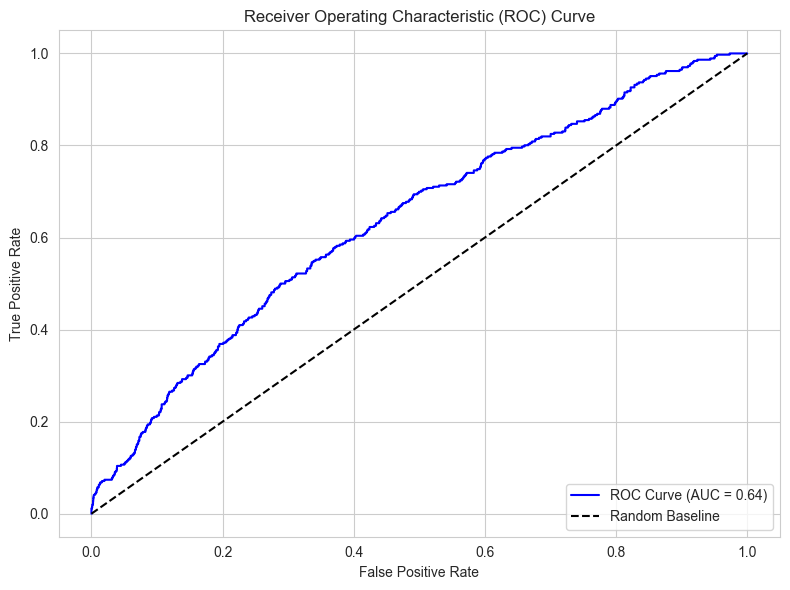

In [114]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})', color='blue')
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

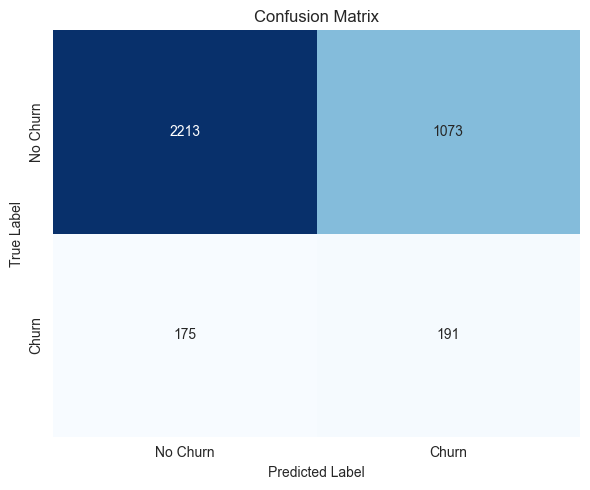

In [115]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### Feature Importance

In [116]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()

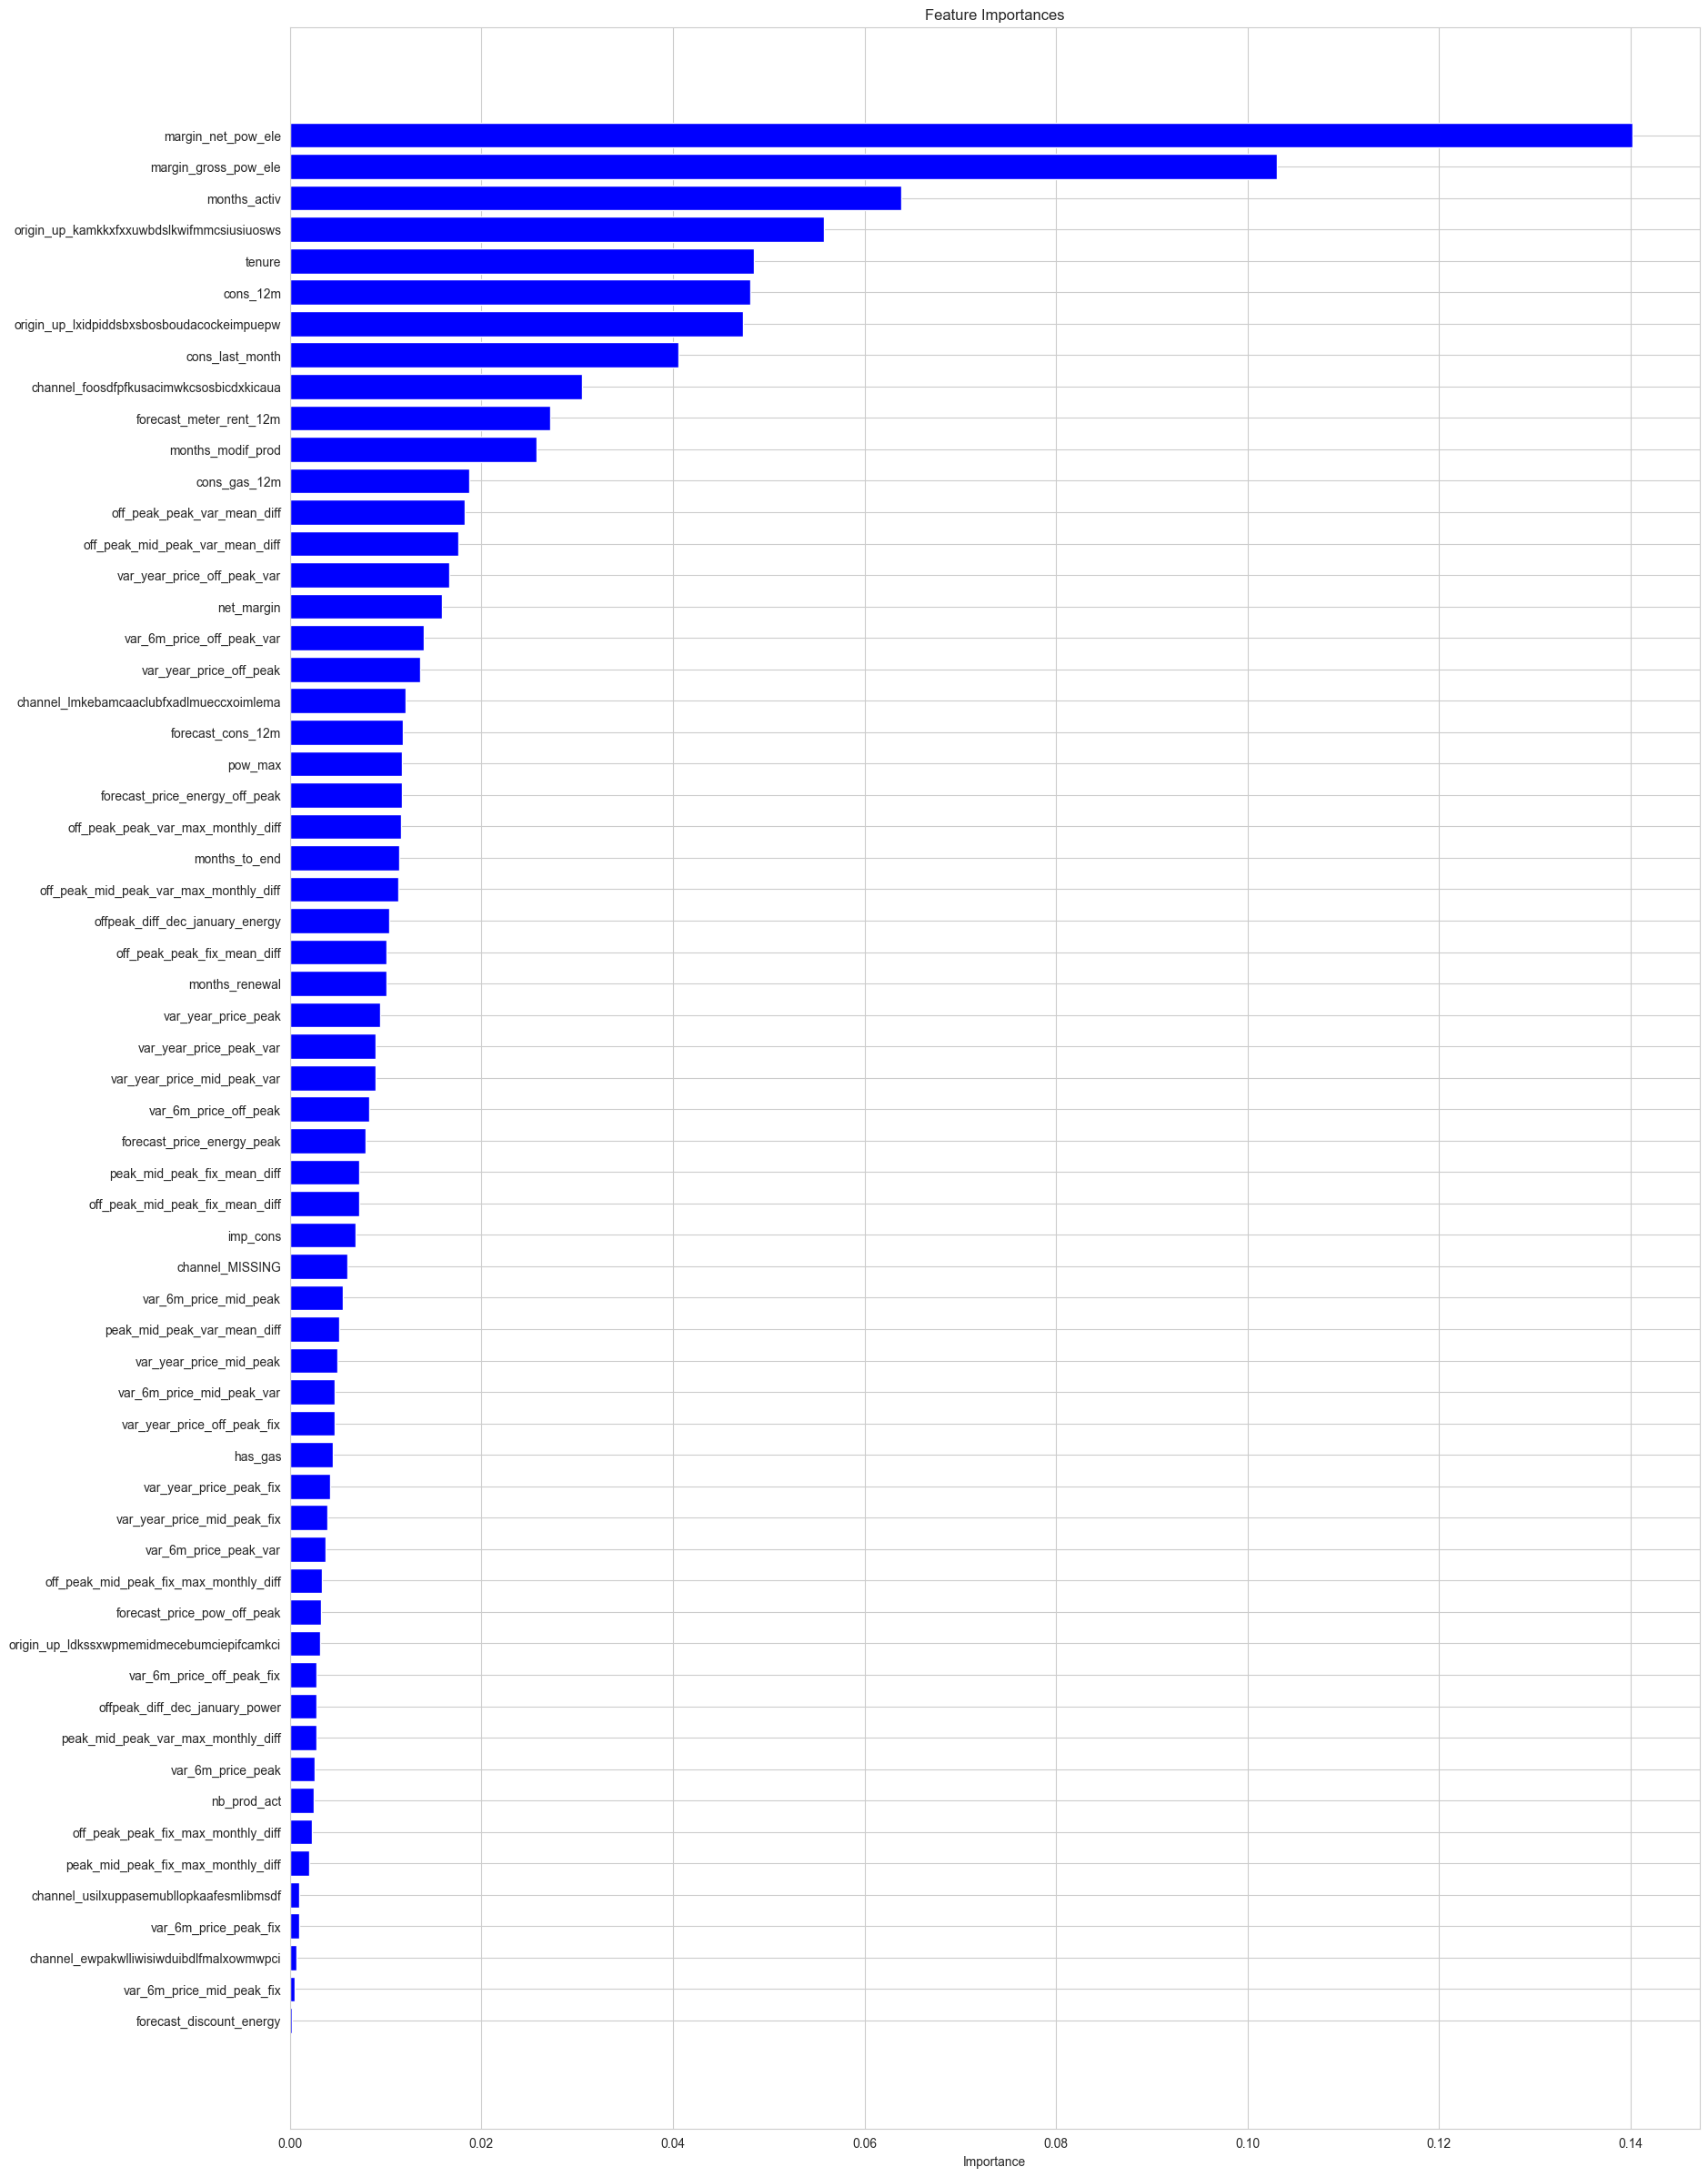

[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   6.6s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   4.4s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.7s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   1.8s
[CV] END bootstrap=False, class_weight=balanced, max_depth=30, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   5.0s
[CV] END bootstrap=False, class_weigh

In [117]:
plt.figure(figsize=(20, 30))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

### Summary: Random Forest – Customer Churn Prediction

We ran `GridSearchCV` with 1,620 parameter combinations across 3-fold cross-validation, resulting in **4,860 total model fits** to find the best-performing Random Forest configuration. The model was trained on class-weighted data (class_weight='balanced') to address churn class imbalance.

#### Evaluation Metrics Used:
- **Accuracy**: Overall prediction correctness.
- **ROC AUC Score**: Measures how well the model separates churners vs non-churners across all thresholds.
- **Precision, Recall, F1-Score**: Useful for understanding churn prediction performance at the class level.
---
#### Model Performance:
- **Accuracy**: 0.66  
- **ROC AUC Score**: 0.64  
- **Churn Recall**: 0.55  
- We’ve made solid progress —> the model now identifies more than half of the churners, compared to just 10% in previous versions.
---
#### Observations:
- While overall accuracy is modest, the **churn recall (0.55)** shows that the model can identify a meaningful portion of at-risk customers.
- However, **precision for churners is low (0.16)**, indicating a higher false positive rate which may be acceptable in proactive churn prevention strategies.
- **Margin Gross Power Electric & Margin Net Power Electric** are key factors driving churn in this model.